# PROJET 7 : Implémentez un modèle de scoring
*Marina BOUCHER (Mai 2023)*

--------------------------------------------------------

## CONTEXTE DU PROJET

Vous êtes Data Scientist au sein d'une société financière, nommée "Prêt à dépenser", qui propose des crédits à la consommation pour des personnes ayant peu ou pas du tout d'historique de prêt.

L’entreprise souhaite mettre en œuvre un outil de “scoring crédit” pour calculer la probabilité qu’un client rembourse son crédit, puis classifie la demande en crédit accordé ou refusé. Elle souhaite donc développer un algorithme de classification en s’appuyant sur des sources de données variées (données comportementales, données provenant d'autres institutions financières, etc.).

De plus, les chargés de relation client ont fait remonter le fait que les clients sont de plus en plus demandeurs de transparence vis-à-vis des décisions d’octroi de crédit. Cette demande de transparence des clients va tout à fait dans le sens des valeurs que l’entreprise veut incarner.

Prêt à dépenser décide donc de développer un dashboard interactif pour que les chargés de relation client puissent à la fois expliquer de façon la plus transparente possible les décisions d’octroi de crédit, mais également permettre à leurs clients de disposer de leurs informations personnelles et de les explorer facilement. 

**Votre mission :**  
- Construire un modèle de scoring qui donnera une prédiction sur la probabilité de faillite d'un client de façon automatique.  
- Construire un dashboard interactif à destination des gestionnaires de la relation client permettant d'interpréter les prédictions faites par le modèle, et d’améliorer la connaissance client des chargés de relation client.  
- Mettre en production le modèle de scoring de prédiction à l’aide d’une API, ainsi que le dashboard interactif qui appelle l’API pour les prédictions. 

**Spécifications du dashboard :**
- Permettre de visualiser le score et l’interprétation de ce score pour chaque client de façon intelligible pour une personne non experte en data science.
- Permettre de visualiser des informations descriptives relatives à un client (via un système de filtre).
- Permettre de comparer les informations descriptives relatives à un client à l’ensemble des clients ou à un groupe de clients similaires.

## DONNEES DU PROJET

Voici les données dont vous aurez besoin pour réaliser le dashboard :  
https://www.kaggle.com/c/home-credit-default-risk/data  
Pour plus de simplicité, vous pouvez les télécharger à cette adresse :  
https://s3-eu-west-1.amazonaws.com/static.oc-static.com/prod/courses/files/Parcours_data_scientist/Projet+-+Impl%C3%A9menter+un+mod%C3%A8le+de+scoring/Projet+Mise+en+prod+-+home-credit-default-risk.zip

## IMPORT DES LIBRAIRIES

In [1]:
import os, time
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import PolynomialFeatures
from sklearn.impute import SimpleImputer
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import roc_curve, auc, confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import f1_score, fbeta_score, roc_auc_score
from sklearn.metrics import make_scorer
from sklearn.linear_model import LogisticRegression
import lightgbm as lgb
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE

from mlflow.models.signature import infer_signature
import mlflow.sklearn

import gc 

from evidently.report import Report
from evidently.metric_preset import DataDriftPreset

import warnings
warnings.filterwarnings('ignore')

/Users/Marina/Applications/anaconda3/lib/python3.10/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/Marina/Applications/anaconda3/lib/python3.10/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/Marina/Applications/anaconda3/lib/python3.10/site-packages/

## CHARGEMENT DES FONCTIONS

In [2]:
def shape_df(df):
    print("Le tableau de données possède", df.shape[0], 
          "lignes et", df.shape[1], "colonnes.")
    
def primary_key(df, columns_list):
    if len(df.groupby(columns_list).size().reset_index(name='Freq')) == len(df):
        print("La/les colonne(s) de la liste est/sont une clé primaire du jeu de données.")
    else:
        print("La/Les colonne(s) de la liste n'est/ne sont pas une clé primaire du jeu de données.")

In [3]:
def scores(model_name, model, train, val, 
           train_labels, val_labels, results,
           fit_params = {}, threshold = 0.5):
    
    with mlflow.start_run(run_name = model_name):
        train_start = time.time()
        model.fit(train, train_labels, **fit_params)
        train_time = time.time() - train_start
        predict_start = time.time()
        val_pred_proba = model.predict_proba(val)[:, 1]
        val_pred = (val_pred_proba >= threshold).astype(int)
        predict_time = time.time() - predict_start
        train_pred_proba = model.predict_proba(train)[:, 1]
        train_pred = (train_pred_proba >= threshold).astype(int)

        train_accuracy = accuracy_score(train_labels, train_pred)
        train_precision = precision_score(train_labels, train_pred)
        train_recall = recall_score(train_labels, train_pred)
        train_F1_score = f1_score(train_labels, train_pred)
        train_F2_score = fbeta_score(train_labels, train_pred, beta = 2)
        train_roc_auc = roc_auc_score(train_labels, train_pred_proba)

        val_accuracy = accuracy_score(val_labels, val_pred)
        val_precision = precision_score(val_labels, val_pred)
        val_recall = recall_score(val_labels, val_pred)
        val_F1_score = f1_score(val_labels, val_pred)
        val_F2_score = fbeta_score(val_labels, val_pred, beta = 2)
        val_roc_auc = roc_auc_score(val_labels, val_pred_proba)

        mlflow.log_metric("train_accuracy", train_accuracy)
        mlflow.log_metric("val_accuracy", val_accuracy)
        mlflow.log_metric("train_precision", train_precision)
        mlflow.log_metric("val_precision", val_precision)
        mlflow.log_metric("train_recall", train_recall)
        mlflow.log_metric("val_recall", val_recall)
        mlflow.log_metric("train_F1_score", train_F1_score)
        mlflow.log_metric("val_F1_score", val_F1_score)
        mlflow.log_metric("train_F2_score", train_F2_score)
        mlflow.log_metric("val_F2_score", val_F2_score)
        mlflow.log_metric("train_roc_auc", train_roc_auc)
        mlflow.log_metric("val_roc_auc", val_roc_auc)
              
        signature = infer_signature(train, train_pred)
        mlflow.sklearn.log_model(model, f'{model_name}', signature=signature)
    
    print('Results on validation set:')
    print(f'Accuracy score:   {val_accuracy : .3}')
    print(f'Precision score:  {val_precision : .3}')
    print(f'Recall score:     {val_recall : .3}')
    print(f'F1 score:         {val_F1_score : .3}')
    print(f'F2 score:         {val_F2_score : .2}') 
    print(f'ROCAUC score:     {val_roc_auc : .3}')

    tn, fp, fn, tp = confusion_matrix(val_labels, val_pred).ravel()
    fn_value = 10
    fp_value = 1
    cost = fn*fn_value + fp*fp_value
    
    results.append([model_name, 
                    tn, fp, fn, tp, cost,
                    train_accuracy, val_accuracy, 
                    train_precision, val_precision,
                    train_recall, val_recall,
                    train_F1_score, val_F1_score,
                    train_F2_score, val_F2_score,
                    train_roc_auc, val_roc_auc,
                    train_time, predict_time])
    
    df_results = pd.DataFrame(results, columns=['classifier',
                                                'TN_val', 'FP_val', 'FN_val', 'TP_val',
                                                'cost',
                                                'train_accuracy', 'val_accuracy', 
                                                'train_precision', 'val_precision',
                                                'train_recall', 'val_recall',
                                                'train_F1_score', 'val_F1_score',
                                                'train_F2_score', 'val_F2_score',
                                                'train_roc_auc', 'val_roc_auc',
                                                'train_time', 'predict_time'])
    
    
    conf_mx = confusion_matrix(val_labels, val_pred)
    fig = plt.figure(figsize=(4, 3))
    sns.heatmap(conf_mx, cmap=plt.cm.gray, annot=True, fmt=".0f", 
                xticklabels=['0', '1'], yticklabels=['0', '1'] )
    plt.title("Matrice de confusion\n Validation set (%)", 
              fontsize = 10, y = 1.02, fontweight = 'bold')
    plt.xlabel("Classes prédites")
    plt.ylabel("Classes réelles")
    fig.savefig(f'Représentation_graph/conf_mx_{model_name}.png', dpi=(100), bbox_inches='tight')
    plt.show()
    
    return df_results

In [4]:
def ROC_curve(model_name, model, val, val_labels):
    val_pred_proba = model.predict_proba(val)[:, 1]
    fpr, tpr, thresholds = roc_curve(val_labels, val_pred_proba)
    roc_auc = auc(fpr, tpr)
    
    fig = plt.figure(figsize = (4, 3))
    plt.title('Receiver Operating Characteristic',
              fontsize = 10, y = 1.02, fontweight = 'bold')
    plt.plot(fpr, tpr, color = 'red', 
             label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0,1], [0,1], linestyle = '--')
    plt.axis('tight')
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')         
    fig.savefig(f'Représentation_graph/ROC_curve_{model_name}.png', 
                bbox_inches = "tight", transparent = True)
    plt.show()

Fonctions ci-après extraites de ce Kaggle :  
https://www.kaggle.com/code/willkoehrsen/introduction-to-manual-feature-engineering/notebook

In [5]:
# Fonction de calcul des aggrégats sur les variables numériques
def agg_numeric(df, group_var, df_name):
    """Aggregates the numeric values in a dataframe. This can
    be used to create features for each instance of the grouping variable.
    
    Parameters
    --------
        df (dataframe): 
            the dataframe to calculate the statistics on
        group_var (string): 
            the variable by which to group df
        df_name (string): 
            the variable used to rename the columns
        
    Return
    --------
        agg (dataframe): 
            a dataframe with the statistics aggregated for 
            all numeric columns. Each instance of the grouping variable will have 
            the statistics (mean, min, max, sum; currently supported) calculated. 
            The columns are also renamed to keep track of features created.
    
    """
    # Remove id variables other than grouping variable
    for col in df:
        if col != group_var and 'SK_ID' in col:
            df = df.drop(columns = col)
            
    group_ids = df[group_var]
    numeric_df = df.select_dtypes('number')
    numeric_df[group_var] = group_ids

    # Group by the specified variable and calculate the statistics
    agg = numeric_df.groupby(group_var).agg(['count', 'mean', 'max', 'min', 'sum']).reset_index()

    # Need to create new column names
    columns = [group_var]

    # Iterate through the variables names
    for var in agg.columns.levels[0]:
        # Skip the grouping variable
        if var != group_var:
            # Iterate through the stat names
            for stat in agg.columns.levels[1][:-1]:
                # Make a new column name for the variable and stat
                columns.append('%s_%s_%s' % (df_name, var, stat))

    agg.columns = columns
    
    # Remove the columns with all redundant values
    _, idx = np.unique(agg, axis = 1, return_index=True)
    agg = agg.iloc[:, idx]
    
    return agg

In [6]:
# Fonction de calcul du nombre de modalités par variable catégorielle pour chaque client
def count_categorical(df, group_var, df_name):
    """Computes counts and normalized counts for each observation
    of `group_var` of each unique category in every categorical variable
    
    Parameters
    --------
    df : dataframe 
        The dataframe to calculate the value counts for.
        
    group_var : string
        The variable by which to group the dataframe. For each unique
        value of this variable, the final dataframe will have one row
        
    df_name : string
        Variable added to the front of column names to keep track of columns

    
    Return
    --------
    categorical : dataframe
        A dataframe with counts and normalized counts of each unique category in every categorical variable
        with one row for every unique value of the `group_var`.
        
    """
    
    # Select the categorical columns
    categorical = pd.get_dummies(df.select_dtypes('object'))

    # Make sure to put the identifying id on the column
    categorical[group_var] = df[group_var]

    # Groupby the group var and calculate the sum and mean
    categorical = categorical.groupby(group_var).agg(['sum', 'mean'])
    
    column_names = []
    
    # Iterate through the columns in level 0
    for var in categorical.columns.levels[0]:
        # Iterate through the stats in level 1
        for stat in ['count', 'count_norm']:
            # Make a new column name
            column_names.append('%s_%s_%s' % (df_name, var, stat))
    
    categorical.columns = column_names
    
    # Remove duplicate columns by values
    _, idx = np.unique(categorical, axis = 1, return_index = True)
    categorical = categorical.iloc[:, idx]
    
    return categorical

In [7]:
# Fonction  de calcul des aggrégats par client
def aggregate_client(df, group_vars, df_names):
    """Aggregate a dataframe with data at the loan level 
    at the client level
    
    Args:
        df (dataframe): data at the loan level
        group_vars (list of two strings): grouping variables for the loan 
        and then the client (example ['SK_ID_PREV', 'SK_ID_CURR'])
        names (list of two strings): names to call the resulting columns
        (example ['cash', 'client'])
        
    Returns:
        df_client (dataframe): aggregated numeric stats at the client level. 
        Each client will have a single row with all the numeric data aggregated
    """
    
    # Aggregate the numeric columns
    df_agg = agg_numeric(df, group_var = group_vars[0], df_name = df_names[0])
    
    # If there are categorical variables
    if any(df.dtypes == 'category'):
    
        # Count the categorical columns
        df_counts = agg_categorical(df, group_var = group_vars[0], df_name = df_names[0])

        # Merge the numeric and categorical
        df_by_loan = df_counts.merge(df_agg, on = group_vars[0], how = 'outer')

        gc.enable()
        del df_agg, df_counts
        gc.collect()

        # Merge to get the client id in dataframe
        df_by_loan = df_by_loan.merge(df[[group_vars[0], group_vars[1]]], on = group_vars[0], how = 'left')

        # Remove the loan id
        df_by_loan = df_by_loan.drop(columns = [group_vars[0]])

        # Aggregate numeric stats by column
        df_by_client = agg_numeric(df_by_loan, group_var = group_vars[1], df_name = df_names[1])

        
    # No categorical variables
    else:
        # Merge to get the client id in dataframe
        df_by_loan = df_agg.merge(df[[group_vars[0], group_vars[1]]], on = group_vars[0], how = 'left')
        
        gc.enable()
        del df_agg
        gc.collect()
        
        # Remove the loan id
        df_by_loan = df_by_loan.drop(columns = [group_vars[0]])
        
        # Aggregate numeric stats by column
        df_by_client = agg_numeric(df_by_loan, group_var = group_vars[1], df_name = df_names[1])
        
    # Memory management
    gc.enable()
    del df, df_by_loan
    gc.collect()

    return df_by_client

In [8]:
# Fonction calculant le taux de manquants des colonnes 
# et supprimant les colonnes avec taux > threshlold
def remove_missing_columns(train, test, threshold = 90):
    # Calculate missing stats for train and test (remember to calculate a percent!)
    train_miss = pd.DataFrame(train.isnull().sum())
    train_miss['percent'] = 100 * train_miss[0] / len(train)
    
    test_miss = pd.DataFrame(test.isnull().sum())
    test_miss['percent'] = 100 * test_miss[0] / len(test)
    
    # list of missing columns for train and test
    missing_train_columns = list(train_miss.index[train_miss['percent'] > threshold])
    missing_test_columns = list(test_miss.index[test_miss['percent'] > threshold])
    
    # Combine the two lists together
    missing_columns = list(set(missing_train_columns + missing_test_columns))
    
    # Print information
    print('There are %d columns with greater than %d%% missing values.' % (len(missing_columns), threshold))
    
    # Drop the missing columns and return
    train = train.drop(columns = missing_columns)
    test = test.drop(columns = missing_columns)
    
    return train, test

## CHARGEMENT ET DESCRIPTION GLOBALE DES DONNEES

### Chargement des données

In [9]:
# Visualisation des fichers/dossiers dans le répertoire
data = "./"
os.listdir(data)

['BOUCHER_Marina_4_presentation_052023.pptx',
 'Représentation_graph',
 '.DS_Store',
 'app_train_cleaned.csv',
 'data_drift_report.html',
 'Projet+Mise+en+prod+-+home-credit-default-risk',
 'app_train_poly.csv',
 'OC_project7',
 'models_results.xlsx',
 'train_corrs_removed_poly.csv',
 'app_test_cleaned.csv',
 'Logo_OpenClassrooms.png',
 '~$te méthodologique.docx',
 'app_train_sampled.csv',
 'Note méthodologique.docx',
 'mlruns',
 'train_corrs_removed_domain.csv',
 'Aide soutenance.docx',
 'train_corrs_removed.csv',
 'BOUCHER_Marina_1_notebook_modelisation_052023.ipynb',
 'Note méthodologique.pdf',
 '.ipynb_checkpoints',
 'models_results.csv',
 '~$BOUCHER_Marina_4_presentation_052023.pptx',
 'app_train_domain.csv']

In [10]:
# Visualisation des fichiers/dossiers dans le répertoire Flipkart
data = "./Projet+Mise+en+prod+-+home-credit-default-risk/"
os.listdir(data)

['application_test.csv',
 'HomeCredit_columns_description.csv',
 'POS_CASH_balance.csv',
 'Outils+Open+Source+MLOps.pdf',
 'credit_card_balance.csv',
 'installments_payments.csv',
 'application_train.csv',
 'bureau.csv',
 'previous_application.csv',
 'bureau_balance.csv',
 'sample_submission.csv']

In [11]:
# Import des fichiers .csv
path_description = data + 'HomeCredit_columns_description.csv'
path_train = data + 'application_train.csv'
path_test = data + 'application_test.csv'
description = pd.read_csv(path_description, encoding="cp1252")
app_train = pd.read_csv(path_train)
app_test = pd.read_csv(path_test)

In [12]:
# Visualisation du fichier décrivant les variables de chaque jeu de données
description

,Unnamed: 0,Table,Row,Description,Special
0,1,application_{train|test}.csv,SK_ID_CURR,ID of loan in our sample,NaN
1,2,application_{train|test}.csv,TARGET,Target variable (1 - client with payment diffi...,NaN
2,5,application_{train|test}.csv,NAME_CONTRACT_TYPE,Identification if loan is cash or revolving,NaN
3,6,application_{train|test}.csv,CODE_GENDER,Gender of the client,NaN
4,7,application_{train|test}.csv,FLAG_OWN_CAR,Flag if the client owns a car,NaN
...,...,...,...,...,...
214,217,installments_payments.csv,NUM_INSTALMENT_NUMBER,On which installment we observe payment,NaN
215,218,installments_payments.csv,DAYS_INSTALMENT,When the installment of previous credit was su...,time only relative to the application
216,219,installments_payments.csv,DAYS_ENTRY_PAYMENT,When was the installments of previous credit p...,time only relative to the application
217,220,installments_payments.csv,AMT_INSTALMENT,What was the prescribed installment amount of ...,NaN


### Première visualisation

In [13]:
# Visualisation des premières lignes de app_train
app_train.head(5)

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [14]:
# Visualisation des dernières lignes de app_train
app_train.tail(5)

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
307506,456251,0,Cash loans,M,N,N,0,157500.0,254700.0,27558.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
307507,456252,0,Cash loans,F,N,Y,0,72000.0,269550.0,12001.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
307508,456253,0,Cash loans,F,N,Y,0,153000.0,677664.0,29979.0,...,0,0,0,0,1.0,0.0,0.0,1.0,0.0,1.0
307509,456254,1,Cash loans,F,N,Y,0,171000.0,370107.0,20205.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
307510,456255,0,Cash loans,F,N,N,0,157500.0,675000.0,49117.5,...,0,0,0,0,0.0,0.0,0.0,2.0,0.0,1.0


In [15]:
# Visualisation de 5 lignes au hasard de app_train
app_train.sample(5)

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
70490,181778,0,Cash loans,F,N,Y,0,202500.0,545040.0,26509.5,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,0.0
69710,180864,0,Cash loans,F,N,Y,0,67500.0,663093.0,19386.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
86716,200648,0,Cash loans,F,N,Y,0,180000.0,427450.5,18828.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
240864,378900,0,Revolving loans,F,N,Y,2,116100.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
289606,435518,0,Cash loans,F,N,Y,0,180000.0,900000.0,38133.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


### Structure

In [16]:
# Calcul du nombre de lignes et de colonnes
print('Training data:')
shape_df(app_train)

Training data:
Le tableau de données possède 307511 lignes et 122 colonnes.


In [17]:
# Visualisation du nombre de valeurs uniques par colonne pour app_train
app_train.nunique().sort_values()

LIVE_CITY_NOT_WORK_CITY         2
FLAG_DOCUMENT_18                2
FLAG_DOCUMENT_14                2
FLAG_MOBIL                      2
FLAG_EMP_PHONE                  2
                            ...  
DAYS_REGISTRATION           15688
DAYS_BIRTH                  17460
EXT_SOURCE_1               114584
EXT_SOURCE_2               119831
SK_ID_CURR                 307511
Length: 122, dtype: int64

In [18]:
# Visualisation du nombre de chaque type de colonnes
app_train.dtypes.value_counts()

float64    65
int64      41
object     16
dtype: int64

In [19]:
# Visualisation du nombre de valeurs uniques par colonne de type 'object'
app_train.select_dtypes('object').apply(pd.Series.nunique, 
                                        axis = 0)

NAME_CONTRACT_TYPE             2
CODE_GENDER                    3
FLAG_OWN_CAR                   2
FLAG_OWN_REALTY                2
NAME_TYPE_SUITE                7
NAME_INCOME_TYPE               8
NAME_EDUCATION_TYPE            5
NAME_FAMILY_STATUS             6
NAME_HOUSING_TYPE              6
OCCUPATION_TYPE               18
WEEKDAY_APPR_PROCESS_START     7
ORGANIZATION_TYPE             58
FONDKAPREMONT_MODE             4
HOUSETYPE_MODE                 3
WALLSMATERIAL_MODE             7
EMERGENCYSTATE_MODE            2
dtype: int64

In [20]:
# Vérification de la clé primaire
print("Training data: 'SK_ID_CURR'")
primary_key(app_train, [app_train['SK_ID_CURR']])

Training data: 'SK_ID_CURR'
La/les colonne(s) de la liste est/sont une clé primaire du jeu de données.


### Statistiques générales

In [21]:
# Visualisation des statistiques générales
pd.options.display.max_columns = None
display(app_train.describe())

,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,TOTALAREA_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
count,307511.000000,307511.000000,307511.000000,3.075110e+05,3.075110e+05,307499.000000,3.072330e+05,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,104582.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307509.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,134133.000000,3.068510e+05,246546.000000,151450.00000,127568.000000,157504.000000,103023.000000,92646.000000,143620.000000,152683.000000,154491.000000,98869.000000,124921.000000,97312.000000,153161.000000,93997.000000,137829.000000,151450.000000,127568.000000,157504.000000,103023.000000,92646.000000,143620.000000,152683.000000,154491.000000,98869.000000,124921.000000,97312.000000,153161.000000,93997.000000,137829.000000,151450.000000,127568.000000,157504.000000,103023.000000,92646.000000,143620.000000,152683.000000,154491.000000,98869.000000,124921.000000,97312.000000,153161.000000,93997.000000,137829.000000,159080.000000,306490.000000,306490.000000,306490.000000,306490.000000,307510.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.00000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,265992.000000,265992.000000,265992.000000,265992.000000,265992.000000,265992.000000
mean,278180.518577,0.080729,0.417052,1.687979e+05,5.990260e+05,27108.573909,5.383962e+05,0.020868,-16036.995067,63815.045904,-4986.120328,-2994.202373,12.061091,0.999997,0.819889,0.199368,0.998133,0.281066,0.056720,2.152665,2.052463,2.031521,12.063419,0.015144,0.050769,0.040659,0.078173,0.230454,0.179555,0.502130,5.143927e-01,0.510853,0.11744,0.088442,0.977735,0.752471,0.044621,0.078942,0.149725,0.226282,0.231894,0.066333,0.100775,0.107399,0.008809,0.028358,0.114231,0.087543,0.977065,0.759637,0.042553,0.074490,0.145193,0.222315,0.228058,0.064958,0.105645,0.105975,0.008076,0.027022,0.117850,0.087955,0.97

<span class="text-info">*Observation :*  
Quelques valeurs seront à vérifier lors de l'analyse exploratoire...</span>

### Ajout des features provenant des autres jeux de données

In [22]:
# Chargement des autres jeux de données 
# Crédits contractés par les clients auprès d'autres institutions financières
path_bureau = data + 'bureau.csv'
bureau = pd.read_csv(path_bureau)  # une ligne par crédit SK_ID_BUREAU
# Informations concernant les crédits précédents mois par mois
path_bureau_balance = data + 'bureau_balance.csv'
bureau_balance = pd.read_csv(path_bureau_balance) # plusieurs lignes par crédit SK_ID_BUREAU
# Crédits contractés par les clients auprès de Home Credit
path_previous = data + 'previous_application.csv'
previous = pd.read_csv(path_previous) # une ligne par crédit SK_ID_PREV
# Point financier mois par mois pour les anciens crédits contractés chez Home Credit
path_cash = data + 'POS_CASH_BALANCE.csv'
cash = pd.read_csv(path_cash) # une ligne par mois par crédit SK_ID_PREV
# Point financier mois par mois sur les cartes de crédit possédées par les clients chez Home Credit
path_credit_card = data + 'credit_card_balance.csv'
credit_card = pd.read_csv(path_credit_card) # une ligne par mois par carte de crédit
# Historique des paiements des crédits précédents chez Home Credit
path_installments = data + 'installments_payments.csv'
installments = pd.read_csv(path_installments) # une ligne par paiement ou paiement manqué

In [23]:
bureau.head()

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,215354,5714462,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,91323.0,0.0,NaN,0.0,Consumer credit,-131,NaN
1,215354,5714463,Active,currency 1,-208,0,1075.0,NaN,NaN,0,225000.0,171342.0,NaN,0.0,Credit card,-20,NaN
2,215354,5714464,Active,currency 1,-203,0,528.0,NaN,NaN,0,464323.5,NaN,NaN,0.0,Consumer credit,-16,NaN
3,215354,5714465,Active,currency 1,-203,0,NaN,NaN,NaN,0,90000.0,NaN,NaN,0.0,Credit card,-16,NaN
4,215354,5714466,Active,currency 1,-629,0,1197.0,NaN,77674.5,0,2700000.0,NaN,NaN,0.0,Consumer credit,-21,NaN


In [24]:
bureau.describe()

,SK_ID_CURR,SK_ID_BUREAU,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
count,1.716428e+06,1.716428e+06,1.716428e+06,1.716428e+06,1.610875e+06,1.082775e+06,5.919400e+05,1.716428e+06,1.716415e+06,1.458759e+06,1.124648e+06,1.716428e+06,1.716428e+06,4.896370e+05
mean,2.782149e+05,5.924434e+06,-1.142108e+03,8.181666e-01,5.105174e+02,-1.017437e+03,3.825418e+03,6.410406e-03,3.549946e+05,1.370851e+05,6.229515e+03,3.791276e+01,-5.937483e+02,1.571276e+04
std,1.029386e+05,5.322657e+05,7.951649e+02,3.654443e+01,4.994220e+03,7.140106e+02,2.060316e+05,9.622391e-02,1.149811e+06,6.774011e+05,4.503203e+04,5.937650e+03,7.207473e+02,3.258269e+05
min,1.000010e+05,5.000000e+06,-2.922000e+03,0.000000e+00,-4.206000e+04,-4.202300e+04,0.000000e+00,0.000000e+00,0.000000e+00,-4.705600e+06,-5.864061e+05,0.000000e+00,-4.194700e+04,0.000000e+00
25%,1.888668e+05,5.463954e+06,-1.666000e+03,0.000000e+00,-1.138000e+03,-1.489000e+03,0.000000e+00,0.000000e+00,5.130000e+04,0.000000e+00,0.000000e+00,0.000000e+00,-9.080000e+02,0.000000e+00
50%,2.780550e+05,5.926304e+06,-9.870000e+02,0.000000e+00,-3.300000e+02,-8.970000e+02,0.000000e+00,0.000000e+00,1.255185e+05,0.000000e+00,0.000000e+00,0.000000e+00,-3.950000e+02,0.000000e+00
75%,3.674260e+05,6.385681e+06,-4.740000e+02,0.000000e+00,4.740000e+02,-4.250000e+02,0.000000e+00,0.000000e+00,3.150000e+05,4.015350e+04,0.000000e+00,0.000000e+00,-3.300000e+01,1.350000e+04
max,4.562550e+05,6.843457e+06,0.000000e+00,2.792000e+03,3.119900e+04,0.000000e+00,1.159872e+08,9.000000e+00,5.850000e+08,1.701000e+08,4.705600e+06,3.756681e+06,3.720000e+02,1.184534e+08


<span class="text-info">*Observation :*  
Il y a plusieurs lignes (plusieurs crédits SK_ID_BUREAU, une ligne par SK_ID_BUREAU) par client (SK_ID_CURR).  
Nous pouvons calculer les aggrégats par client directement en groupant par SK_ID_CURR en applicant la fonction agg_numeric et compter les modalités des colonnes catégorielles avec la fonction count_categorical.</span>

In [25]:
bureau_balance.head()

,SK_ID_BUREAU,MONTHS_BALANCE,STATUS
0,5715448,0,C
1,5715448,-1,C
2,5715448,-2,C
3,5715448,-3,C
4,5715448,-4,C


In [26]:
bureau_balance.describe()

,SK_ID_BUREAU,MONTHS_BALANCE
count,2.729992e+07,2.729992e+07
mean,6.036297e+06,-3.074169e+01
std,4.923489e+05,2.386451e+01
min,5.001709e+06,-9.600000e+01
25%,5.730933e+06,-4.600000e+01
50%,6.070821e+06,-2.500000e+01
75%,6.431951e+06,-1.100000e+01
max,6.842888e+06,0.000000e+00


<span class="text-info">*Observation :*  
Il y a plusieurs lignes par crédit précédent (SK_ID_BUREAU).  
Nous pouvons récupérer l'identifiant client SK_ID_CURR pour chaque ligne, puis utiliser la fonction aggregate_client pour calculer les aggrégats par client et les modalités des colonnes catégorielles.</span>

In [27]:
previous.head()

,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,FLAG_LAST_APPL_PER_CONTRACT,NFLAG_LAST_APPL_IN_DAY,RATE_DOWN_PAYMENT,RATE_INTEREST_PRIMARY,RATE_INTEREST_PRIVILEGED,NAME_CASH_LOAN_PURPOSE,NAME_CONTRACT_STATUS,DAYS_DECISION,NAME_PAYMENT_TYPE,CODE_REJECT_REASON,NAME_TYPE_SUITE,NAME_CLIENT_TYPE,NAME_GOODS_CATEGORY,NAME_PORTFOLIO,NAME_PRODUCT_TYPE,CHANNEL_TYPE,SELLERPLACE_AREA,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
0,2030495,271877,Consumer loans,1730.430,17145.0,17145.0,0.0,17145.0,SATURDAY,15,Y,1,0.0,0.182832,0.867336,XAP,Approved,-73,Cash through the bank,XAP,NaN,Repeater,Mobile,POS,XNA,Country-wide,35,Connectivity,12.0,middle,POS mobile with interest,365243.0,-42.0,300.0,-42.0,-37.0,0.0
1,2802425,108129,Cash loans,25188.615,607500.0,679671.0,NaN,607500.0,THURSDAY,11,Y,1,NaN,NaN,NaN,XNA,Approved,-164,XNA,XAP,Unaccompanied,Repeater,XNA,Cash,x-sell,Contact center,-1,XNA,36.0,low_action,Cash X-Sell: low,365243.0,-134.0,916.0,365243.0,365243.0,1.0
2,2523466,122040,Cash loans,15060.735,112500.0,136444.5,NaN,112500.0,TUESDAY,11,Y,1,NaN,NaN,NaN,XNA,Approved,-301,Cash through the bank,XAP,"Spouse, partner",Repeater,XNA,Cash,x-sell,Credit and cash offices,-1,XNA,12.0,high,Cash X-Sell: high,365243.0,-271.0,59.0,365243.0,365243.0,1.0
3,2819243,176158,Cash loans,47041.335,450000.0,470790.0,NaN,450000.0,MONDAY,7,Y,1,NaN,NaN,NaN,XNA,Approved,-512,Cash through the bank,XAP,NaN,Repeater,XNA,Cash,x-sell,Credit and cash offices,-1,XNA,12.0,middle,Cash X-Sell: middle,365243.0,-482.0,-152.0,-182.0,-177.0,1.0
4,1784265,202054,Cash loans,31924.395,337500.0,404055.0,NaN,337500.0,THURSDAY,9,Y,1,NaN,NaN,NaN,Repairs,Refused,-781,Cash through the bank,HC,NaN,Repeater,XNA,Cash,walk-in,Credit and cash offices,-1,XNA,24.0,high,Cash Street: high,NaN,NaN,NaN,NaN,NaN,NaN


In [28]:
previous.describe()

,SK_ID_PREV,SK_ID_CURR,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,HOUR_APPR_PROCESS_START,NFLAG_LAST_APPL_IN_DAY,RATE_DOWN_PAYMENT,RATE_INTEREST_PRIMARY,RATE_INTEREST_PRIVILEGED,DAYS_DECISION,SELLERPLACE_AREA,CNT_PAYMENT,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
count,1.670214e+06,1.670214e+06,1.297979e+06,1.670214e+06,1.670213e+06,7.743700e+05,1.284699e+06,1.670214e+06,1.670214e+06,774370.000000,5951.000000,5951.000000,1.670214e+06,1.670214e+06,1.297984e+06,997149.000000,997149.000000,997149.000000,997149.000000,997149.000000,997149.000000
mean,1.923089e+06,2.783572e+05,1.595512e+04,1.752339e+05,1.961140e+05,6.697402e+03,2.278473e+05,1.248418e+01,9.964675e-01,0.079637,0.188357,0.773503,-8.806797e+02,3.139511e+02,1.605408e+01,342209.855039,13826.269337,33767.774054,76582.403064,81992.343838,0.332570
std,5.325980e+05,1.028148e+05,1.478214e+04,2.927798e+05,3.185746e+05,2.092150e+04,3.153966e+05,3.334028e+00,5.932963e-02,0.107823,0.087671,0.100879,7.790997e+02,7.127443e+03,1.456729e+01,88916.115834,72444.869708,106857.034789,149647.415123,153303.516729,0.471134
min,1.000001e+06,1.000010e+05,0.000000e+00,0.000000e+00,0.000000e+00,-9.000000e-01,0.000000e+00,0.000000e+00,0.000000e+00,-0.000015,0.034781,0.373150,-2.922000e+03,-1.000000e+00,0.000000e+00,-2922.000000,-2892.000000,-2801.000000,-2889.000000,-2874.000000,0.000000
25%,1.461857e+06,1.893290e+05,6.321780e+03,1.872000e+04,2.416050e+04,0.000000e+00,5.084100e+04,1.000000e+01,1.000000e+00,0.000000,0.160716,0.715645,-1.300000e+03,-1.000000e+00,6.000000e+00,365243.000000,-1628.000000,-1242.000000,-1314.000000,-1270.000000,0.000000
50%,1.923110e+06,2.787145e+05,1.125000e+04,7.104600e+04,8.054100e+04,1.638000e+03,1.123200e+05,1.200000e+01,1.000000e+00,0.051605,0.189122,0.835095,-5.810000e+02,3.000000e+00,1.200000e+01,365243.000000,-831.000000,-361.000000,-537.000000,-499.000000,0.000000
75%,2.384280e+06,3.675140e+05,2.065842e+04,1.803600e+05,2.164185e+05,7.740000e+03,2.340000e+05,1.500000e+01,1.000000e+00,0.108909,0.193330,0.852537,-2.800000e+02,8.200000e+01,2.400000e+01,365243.000000,-411.000000,129.000000,-74.000000,-44.000000,1.000000
max,2.845382e+06,4.562550e+05,4.180581e+05,6.905160e+06,6.905160e+06,3.060045e+06,6.905160e+06,2.300000e+01,1.000000e+00,1.000000,1.000000,1.000000,-1.000000e+00,4.000000e+06,8.400000e+01,365243.000000,365243.000000,365243.000000,365243.000000,365243.000000,1.000000


<span class="text-info">*Observation :*  
Il y a plusieurs lignes (plusieurs crédits SK_ID_PREV, une ligne par SK_ID_PREV) par client (SK_ID_CURR).  
Nous pouvons calculer les aggrégats par client directement en groupant par SK_ID_CURR en applicant la fonction agg_numeric et compter les modalités des colonnes catégorielles avec la fonction count_categorical.</span>

In [29]:
cash.head()

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,1803195,182943,-31,48.0,45.0,Active,0,0
1,1715348,367990,-33,36.0,35.0,Active,0,0
2,1784872,397406,-32,12.0,9.0,Active,0,0
3,1903291,269225,-35,48.0,42.0,Active,0,0
4,2341044,334279,-35,36.0,35.0,Active,0,0


In [30]:
cash.describe()

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,SK_DPD,SK_DPD_DEF
count,1.000136e+07,1.000136e+07,1.000136e+07,9.975287e+06,9.975271e+06,1.000136e+07,1.000136e+07
mean,1.903217e+06,2.784039e+05,-3.501259e+01,1.708965e+01,1.048384e+01,1.160693e+01,6.544684e-01
std,5.358465e+05,1.027637e+05,2.606657e+01,1.199506e+01,1.110906e+01,1.327140e+02,3.276249e+01
min,1.000001e+06,1.000010e+05,-9.600000e+01,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.434405e+06,1.895500e+05,-5.400000e+01,1.000000e+01,3.000000e+00,0.000000e+00,0.000000e+00
50%,1.896565e+06,2.786540e+05,-2.800000e+01,1.200000e+01,7.000000e+00,0.000000e+00,0.000000e+00
75%,2.368963e+06,3.674290e+05,-1.300000e+01,2.400000e+01,1.400000e+01,0.000000e+00,0.000000e+00
max,2.843499e+06,4.562550e+05,-1.000000e+00,9.200000e+01,8.500000e+01,4.231000e+03,3.595000e+03


In [31]:
credit_card.head()

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,AMT_PAYMENT_CURRENT,AMT_PAYMENT_TOTAL_CURRENT,AMT_RECEIVABLE_PRINCIPAL,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,2562384,378907,-6,56.970,135000,0.0,877.5,0.0,877.5,1700.325,1800.0,1800.0,0.000,0.000,0.000,0.0,1,0.0,1.0,35.0,Active,0,0
1,2582071,363914,-1,63975.555,45000,2250.0,2250.0,0.0,0.0,2250.000,2250.0,2250.0,60175.080,64875.555,64875.555,1.0,1,0.0,0.0,69.0,Active,0,0
2,1740877,371185,-7,31815.225,450000,0.0,0.0,0.0,0.0,2250.000,2250.0,2250.0,26926.425,31460.085,31460.085,0.0,0,0.0,0.0,30.0,Active,0,0
3,1389973,337855,-4,236572.110,225000,2250.0,2250.0,0.0,0.0,11795.760,11925.0,11925.0,224949.285,233048.970,233048.970,1.0,1,0.0,0.0,10.0,Active,0,0
4,1891521,126868,-1,453919.455,450000,0.0,11547.0,0.0,11547.0,22924.890,27000.0,27000.0,443044.395,453919.455,453919.455,0.0,1,0.0,1.0,101.0,Active,0,0


In [32]:
credit_card.describe()

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,AMT_PAYMENT_CURRENT,AMT_PAYMENT_TOTAL_CURRENT,AMT_RECEIVABLE_PRINCIPAL,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,SK_DPD,SK_DPD_DEF
count,3.840312e+06,3.840312e+06,3.840312e+06,3.840312e+06,3.840312e+06,3.090496e+06,3.840312e+06,3.090496e+06,3.090496e+06,3.535076e+06,3.072324e+06,3.840312e+06,3.840312e+06,3.840312e+06,3.840312e+06,3.090496e+06,3.840312e+06,3.090496e+06,3.090496e+06,3.535076e+06,3.840312e+06,3.840312e+06
mean,1.904504e+06,2.783242e+05,-3.452192e+01,5.830016e+04,1.538080e+05,5.961325e+03,7.433388e+03,2.881696e+02,2.968805e+03,3.540204e+03,1.028054e+04,7.588857e+03,5.596588e+04,5.808881e+04,5.809829e+04,3.094490e-01,7.031439e-01,4.812496e-03,5.594791e-01,2.082508e+01,9.283667e+00,3.316220e-01
std,5.364695e+05,1.027045e+05,2.666775e+01,1.063070e+05,1.651457e+05,2.822569e+04,3.384608e+04,8.201989e+03,2.079689e+04,5.600154e+03,3.607808e+04,3.200599e+04,1.025336e+05,1.059654e+05,1.059718e+05,1.100401e+00,3.190347e+00,8.263861e-02,3.240649e+00,2.005149e+01,9.751570e+01,2.147923e+01
min,1.000018e+06,1.000060e+05,-9.600000e+01,-4.202502e+05,0.000000e+00,-6.827310e+03,-6.211620e+03,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-4.233058e+05,-4.202502e+05,-4.202502e+05,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.434385e+06,1.895170e+05,-5.500000e+01,0.000000e+00,4.500000e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.523700e+02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.000000e+00,0.000000e+00,0.000000e+00
50%,1.897122e+06,2.783960e+05,-2.800000e+01,0.000000e+00,1.125000e+05,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.702700e+03,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.500000e+01,0.000000e+00,0.000000e+00
75%,2.369328e+06,3.675800e+05,-1.100000e+01,8.904669e+04,1.800000e+05,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,6.633911e+03,9.000000e+03,6.750000e+03,8.535924e+04,8.889949e+04,8.891451e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.200000e+01,0.000000e+00,0.000000e+00
max,2.843496e+06,4.562500e+05,-1.000000e+00,1.505902e+06,1.350000e+06,2.115000e+06,2.287098e+06,1.529847e+06,2.239274e+06,2.028820e+05,4.289207e+06,4.278316e+06,1.472317e+06,1.493338e+06,1.493338e+06,5.100000e+01,1.650000e+02,1.200000e+01,1.650000e+02,1.200000e+02,3.260000e+03,3.260000e+03


In [33]:
installments.head()

,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
0,1054186,161674,1.0,6,-1180.0,-1187.0,6948.360,6948.360
1,1330831,151639,0.0,34,-2156.0,-2156.0,1716.525,1716.525
2,2085231,193053,2.0,1,-63.0,-63.0,25425.000,25425.000
3,2452527,199697,1.0,3,-2418.0,-2426.0,24350.130,24350.130
4,2714724,167756,1.0,2,-1383.0,-1366.0,2165.040,2160.585


In [34]:
installments.describe()

,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
count,1.360540e+07,1.360540e+07,1.360540e+07,1.360540e+07,1.360540e+07,1.360250e+07,1.360540e+07,1.360250e+07
mean,1.903365e+06,2.784449e+05,8.566373e-01,1.887090e+01,-1.042270e+03,-1.051114e+03,1.705091e+04,1.723822e+04
std,5.362029e+05,1.027183e+05,1.035216e+00,2.666407e+01,8.009463e+02,8.005859e+02,5.057025e+04,5.473578e+04
min,1.000001e+06,1.000010e+05,0.000000e+00,1.000000e+00,-2.922000e+03,-4.921000e+03,0.000000e+00,0.000000e+00
25%,1.434191e+06,1.896390e+05,0.000000e+00,4.000000e+00,-1.654000e+03,-1.662000e+03,4.226085e+03,3.398265e+03
50%,1.896520e+06,2.786850e+05,1.000000e+00,8.000000e+00,-8.180000e+02,-8.270000e+02,8.884080e+03,8.125515e+03
75%,2.369094e+06,3.675300e+05,1.000000e+00,1.900000e+01,-3.610000e+02,-3.700000e+02,1.671021e+04,1.610842e+04
max,2.843499e+06,4.562550e+05,1.780000e+02,2.770000e+02,-1.000000e+00,-1.000000e+00,3.771488e+06,3.771488e+06


<span class="text-info">*Observation :*  
Sur ces 3 derniers jeux de données, il y a plusieurs lignes par crédit SK_ID_PREV.  
Nous pouvons utiliser la fonction aggregate_client pour calculer les aggrégats par client et les modalités des colonnes catégorielles.</span>

In [35]:
# Traitement du dataframe 'bureau' par client
bureau_counts = count_categorical(bureau, 
                                  group_var = 'SK_ID_CURR', 
                                  df_name = 'bureau')
bureau_agg = agg_numeric(bureau.drop(columns = ['SK_ID_BUREAU']), 
                         group_var = 'SK_ID_CURR', 
                         df_name = 'bureau')

In [36]:
# Traitement du dataframe 'bureau_balance' par client
bureau_balance = bureau_balance.merge(bureau[['SK_ID_BUREAU', 'SK_ID_CURR']], 
                                      on = 'SK_ID_BUREAU', 
                                      how = 'left')
bureau_balance_by_client = aggregate_client(bureau_balance, 
                                            group_vars = ['SK_ID_BUREAU', 'SK_ID_CURR'], 
                                            df_names = ['loan', 'client'])

In [37]:
# Traitement du dataframe 'previous' par client
previous_counts = count_categorical(previous, 
                                    group_var = 'SK_ID_CURR', 
                                    df_name = 'previous')
previous_agg = agg_numeric(previous.drop(columns = ['SK_ID_PREV']), 
                           group_var = 'SK_ID_CURR', 
                           df_name = 'previous')

In [38]:
# Traitement du dataframe 'cash' par client
cash_by_client = aggregate_client(cash, 
                                  group_vars = ['SK_ID_PREV', 'SK_ID_CURR'], 
                                  df_names = ['cash', 'client'])

In [39]:
# Traitement du dataframe 'credit_card' par client
credit_card_by_client = aggregate_client(credit_card, 
                                         group_vars = ['SK_ID_PREV', 'SK_ID_CURR'], 
                                         df_names = ['card', 'client'])

In [40]:
# Traitement du dataframe 'installments' par client
installments_by_client = aggregate_client(installments, 
                                          group_vars = ['SK_ID_PREV', 'SK_ID_CURR'], 
                                          df_names = ['installments', 'client'])

In [41]:
# Fusion des données créées avec 'app_train'
app_train = app_train.merge(bureau_counts, on = 'SK_ID_CURR', how = 'left')
app_train = app_train.merge(bureau_agg, on = 'SK_ID_CURR', how = 'left')
app_train = app_train.merge(bureau_balance_by_client, on = 'SK_ID_CURR', how = 'left')
app_train = app_train.merge(previous_counts, on = 'SK_ID_CURR', how = 'left')
app_train = app_train.merge(previous_agg, on = 'SK_ID_CURR', how = 'left')
app_train = app_train.merge(cash_by_client, on = 'SK_ID_CURR', how = 'left')
app_train = app_train.merge(credit_card_by_client, on = 'SK_ID_CURR', how = 'left')
app_train = app_train.merge(installments_by_client, on = 'SK_ID_CURR', how = 'left')

In [42]:
# Fusion des données créées avec 'app_test'
app_test = app_test.merge(bureau_counts, on = 'SK_ID_CURR', how = 'left')
app_test = app_test.merge(bureau_agg, on = 'SK_ID_CURR', how = 'left')
app_test = app_test.merge(bureau_balance_by_client, on = 'SK_ID_CURR', how = 'left')
app_test = app_test.merge(previous_counts, on = 'SK_ID_CURR', how = 'left')
app_test = app_test.merge(previous_agg, on = 'SK_ID_CURR', how = 'left')
app_test = app_test.merge(cash_by_client, on = 'SK_ID_CURR', how = 'left')
app_test = app_test.merge(credit_card_by_client, on = 'SK_ID_CURR', how = 'left')
app_test = app_test.merge(installments_by_client, on = 'SK_ID_CURR', how = 'left')

In [43]:
# Suppression des dataframes intermédiaires créés
gc.enable()
del (bureau_counts, bureau_agg, bureau_balance_by_client, 
     previous_counts, previous_agg, cash_by_client, 
     credit_card_by_client, installments_by_client)
gc.collect()

0

### Doublons et valeurs manquantes

In [44]:
# Visualisation de la proportion de valeurs nulles par colonne pour app_train
mis_values_table = app_train.isna().mean()\
                            .sort_values(ascending = False)\
                            .to_frame('% of missing values')\
                            .round(3)*100
mis_values_table.head(20)

,% of missing values
previous_RATE_INTEREST_PRIVILEGED_min,98.5
previous_RATE_INTEREST_PRIMARY_min,98.5
previous_RATE_INTEREST_PRIVILEGED_max,98.5
previous_RATE_INTEREST_PRIMARY_mean,98.5
previous_RATE_INTEREST_PRIVILEGED_mean,98.5
previous_RATE_INTEREST_PRIMARY_max,98.5
client_card_AMT_PAYMENT_CURRENT_mean_min,80.1
client_card_AMT_PAYMENT_CURRENT_mean_mean,80.1
client_card_AMT_PAYMENT_CURRENT_min_max,80.1
client_card_AMT_PAYMENT_CURRENT_mean_max,80.1


In [45]:
# Suppression des colonnes avec plus de 75% de manquants
app_train, app_test = remove_missing_columns(app_train, 
                                             app_test,
                                             threshold = 75)

There are 69 columns with greater than 75% missing values.


In [46]:
# Visualisation des doublons 
app_train.duplicated().sum()

0

In [47]:
# Calcul du nombre de lignes et de colonnes
print('Training data:')
shape_df(app_train)
print('Testing data:')
shape_df(app_test)

Training data:
Le tableau de données possède 307511 lignes et 1075 colonnes.
Testing data:
Le tableau de données possède 48744 lignes et 1074 colonnes.


### Encodage des variables catégorielles

In [48]:
# Label encoding pour les variables avec 2 uniques catégories
le = LabelEncoder()
le_count = 0

for col in app_train:
    if app_train[col].dtype == 'object':
        if len(list(app_train[col].unique())) <= 2:
            le.fit(app_train[col])
            app_train[col] = le.transform(app_train[col])
            app_test[col] = le.transform(app_test[col])
            le_count += 1
            
print('%d columns were label encoded.' % le_count)

3 columns were label encoded.


In [49]:
# Visualisation de format avant one-hot encoding
print('Training Features shape: ', app_train.shape)
print('Testing Features shape: ', app_test.shape)

Training Features shape:  (307511, 1075)
Testing Features shape:  (48744, 1074)


In [50]:
# One-hot encoding pour les variables catégorielles à 3 catégories uniques ou plus
app_train = pd.get_dummies(app_train)
app_test = pd.get_dummies(app_test)

print('Training Features shape: ', app_train.shape)
print('Testing Features shape: ', app_test.shape)

Training Features shape:  (307511, 1196)
Testing Features shape:  (48744, 1192)


<span class="text-info">*Observation :*  
Plus de colonnes créées sur le training que sur le test, car plus de catégories dans training set. 
Un alignement des 2 sets est nécessaire.</span>

In [51]:
# Extraction de la target du training set
train_target = app_train['TARGET']

# Alignement du training and testing set 
# en ne gardant que les colonnes présentes dans les 2 dataframes
app_train, app_test = app_train.align(app_test, 
                                      join = 'inner', 
                                      axis = 1)

# On ajoute à nouveau la colonne target au training set
app_train['TARGET'] = train_target

print('Training Features shape: ', app_train.shape)
print('Testing Features shape: ', app_test.shape)

Training Features shape:  (307511, 1193)
Testing Features shape:  (48744, 1192)


## ANALYSE EXPLORATOIRE
### Distributions des variables

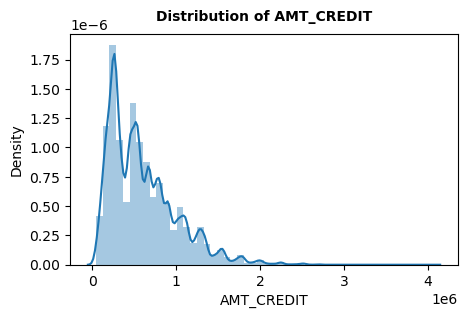

In [52]:
# Visualisation graphique de AMT_CREDIT
plt.figure(figsize = (5,3))
plt.title("Distribution of AMT_CREDIT", 
          fontsize = 10, y = 1.02, fontweight = 'bold')
ax = sns.distplot(app_train["AMT_CREDIT"])

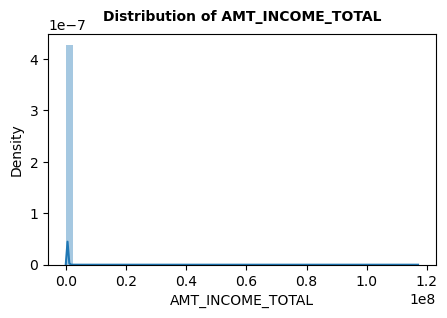

In [53]:
# Visualisation graphique de AMT_INCOME_TOTAL
plt.figure(figsize = (5,3))
plt.title("Distribution of AMT_INCOME_TOTAL", 
          fontsize = 10, y = 1.02, fontweight = 'bold')
ax = sns.distplot(app_train["AMT_INCOME_TOTAL"].dropna())

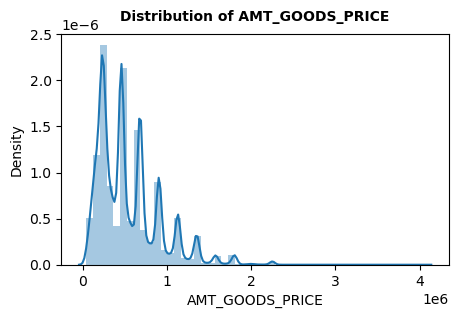

In [54]:
# Visualisation graphique de AMT_GOODS_PRICE
plt.figure(figsize = (5,3))
plt.title("Distribution of AMT_GOODS_PRICE", 
          fontsize = 10, y = 1.02, fontweight = 'bold')
ax = sns.distplot(app_train["AMT_GOODS_PRICE"].dropna())

In [55]:
# Comptage du nombre de client par modalité de la target
# 0 : prêt remboursé dans les temps par le client
# 1 : difficultés de paiements de la part du client
app_train['TARGET'].value_counts()

0    282686
1     24825
Name: TARGET, dtype: int64

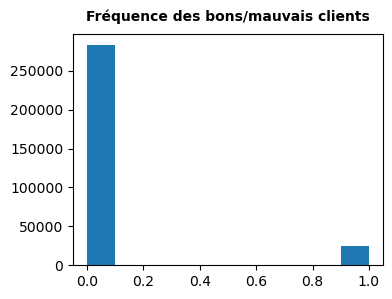

In [56]:
# Visualisation graphique de la distribution des clients
fig = plt.figure(figsize = (4, 3))
plt.hist(app_train['TARGET'])
plt.title('Fréquence des bons/mauvais clients', fontsize = 10, 
          y = 1.02, fontweight = 'bold')
fig.savefig('Représentation_graph/Target_histogramme.png', bbox_inches = "tight", 
            dpi = 400, transparent = True)

<span class="text-info">*Observation :*  
On peut voir un problème d'équilibre entre les bons et les moins bons clients. Il y a beaucoup plus de bons clients que de moins bons clients.  
Ce déséquilibre sera à prendre en compte lors de l'élaboration du modèle de machine learning.</span>

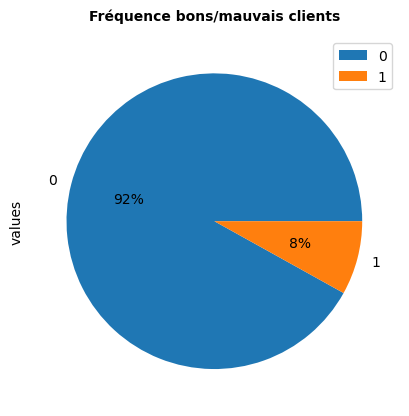

In [57]:
# Visualisation graphique via piechart
tmp = app_train["TARGET"].value_counts()
df = pd.DataFrame({'labels': tmp.index,
                   'values': tmp.values})
df.plot(kind = 'pie', y = 'values', autopct = '%1.0f%%')
ax = plt.title('Fréquence bons/mauvais clients', fontsize = 10, 
               y = 1.02, fontweight = 'bold')

### Traitement des anomalies

In [58]:
# Vérification de la colonne 'DAYS_BIRTH' qui est négative
(app_train['DAYS_BIRTH'] / -365).describe()

count    307511.000000
mean         43.936973
std          11.956133
min          20.517808
25%          34.008219
50%          43.150685
75%          53.923288
max          69.120548
Name: DAYS_BIRTH, dtype: float64

<span class="text-info">*Observation :*  
La colonne 'DAYS_BIRTH' est définie relativement à la date de mise en application du prêt, donc elle est négative.  
Après avoir divisé par 365 et multiplié par -1, on retrouve l'âge des clients, qui est cohérent.</span>

In [59]:
# Vérification de la colonne 'DAYS_EMPLOYED' qui a une valeur extrême
app_train['DAYS_EMPLOYED'].describe()

count    307511.000000
mean      63815.045904
std      141275.766519
min      -17912.000000
25%       -2760.000000
50%       -1213.000000
75%        -289.000000
max      365243.000000
Name: DAYS_EMPLOYED, dtype: float64

<span class="text-info">*Observation :*  
La valeur max représente 1000 ans...</span>

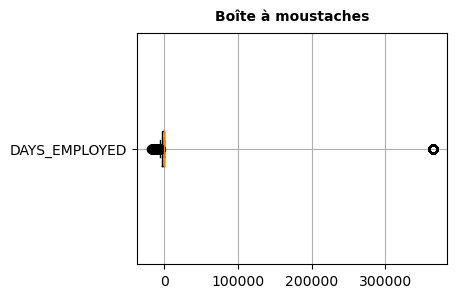

In [60]:
# Visualisation graphique
fig = plt.figure(figsize=(4, 3))
plt.boxplot(app_train['DAYS_EMPLOYED'], vert = False,
            labels=['DAYS_EMPLOYED'])
plt.title("Boîte à moustaches", fontsize = 10, 
          y = 1.02, fontweight = 'bold')
plt.grid()
fig.savefig('Représentation_graph/DAYS_EMPLOYED_boxplot.png', 
            bbox_inches = "tight", 
            dpi = 400, transparent = True)

<span class="text-info">*Observation :*  
La valeur max semble être la seule anomalie. Vérifions la valeur de la target pour les clients possédant cette anomalie.</span>

In [61]:
anom = app_train[app_train['DAYS_EMPLOYED'] == 365243]
non_anom = app_train[app_train['DAYS_EMPLOYED'] != 365243]
print('The non-anomalies default on %0.2f%% of loans.' \
      % (100 * non_anom['TARGET'].mean()))
print('The anomalies default on %0.2f%% of loans.' \
      % (100 * anom['TARGET'].mean()))
print('There are %d anomalous days of employment.' \
      % len(anom))

The non-anomalies default on 8.66% of loans.
The anomalies default on 5.40% of loans.
There are 55374 anomalous days of employment.


<span class="text-info">*Observations :*  
Les anomalies seront remplacées par np.nan, puis une colonne indiquant si la valeur 'DAYS_EMPLOYED' était une anomalie ou non sera créée.  
Les anomalies seront imputées plus tard par une autre valeur pour la modélisation.</span>

There are 9274 anomalies in the test data out of 48744 entries.


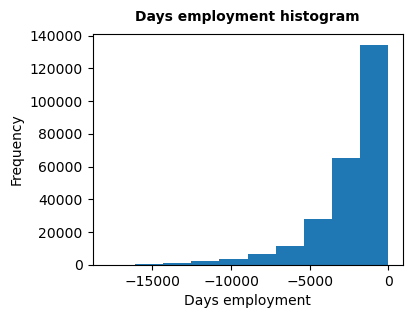

In [62]:
# Création de la colonne 'flag'
app_train['DAYS_EMPLOYED_ANOM'] = app_train["DAYS_EMPLOYED"] == 365243
app_test['DAYS_EMPLOYED_ANOM'] = app_test["DAYS_EMPLOYED"] == 365243

# Remplacement des valeurs anormales par np.nan
app_train['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace = True)
app_test["DAYS_EMPLOYED"].replace({365243: np.nan}, inplace = True)

print('There are %d anomalies in the test data out of %d entries.' \
      % (app_test["DAYS_EMPLOYED_ANOM"].sum(), len(app_test)))

# Visualisation graphique après traitement des anomalies
fig = plt.figure(figsize=(4, 3))
app_train['DAYS_EMPLOYED'].plot.hist()
plt.xlabel('Days employment')
plt.title("Days employment histogram", fontsize = 10, 
          y = 1.02, fontweight = 'bold')
fig.savefig('Représentation_graph/DAYS_EMPLOYED_histogram_après_traitement.png', 
            bbox_inches = "tight", 
            dpi = 400, transparent = True)

In [63]:
# Remplacement des outliers '365243' dans les colonnes avec 'DAYS'
for col in app_train.columns:
    if "DAYS" in col:
        app_train[col] = app_train[col].replace({365243: np.nan})
            
for col in app_test.columns:
    if "DAYS" in col:
        app_test[col] = app_test[col].replace({365243: np.nan})

### Corrélations

In [64]:
# Création de la matrice de corrélation
corr_matrix = app_train.corr(method = 'pearson')

In [65]:
# Visualisation des corrélations avec la target
correlations = corr_matrix['TARGET'].sort_values(ascending = False)
print('Most Positive Correlations:\n', correlations.head(30))
print('\nMost Negative Correlations:\n', correlations.tail(15))

Most Positive Correlations:
 TARGET                                              1.000000
previous_DAYS_FIRST_DRAWING_max                     0.148409
client_card_CNT_DRAWINGS_CURRENT_max_max            0.101389
client_card_CNT_DRAWINGS_CURRENT_max_mean           0.100921
client_card_CNT_DRAWINGS_CURRENT_max_min            0.100648
previous_DAYS_FIRST_DRAWING_min                     0.095787
bureau_DAYS_CREDIT_mean                             0.089729
client_card_AMT_BALANCE_mean_max                    0.087617
client_card_AMT_BALANCE_mean_mean                   0.087177
client_card_AMT_BALANCE_mean_min                    0.086997
client_card_AMT_TOTAL_RECEIVABLE_mean_max           0.086932
client_card_AMT_RECIVABLE_mean_max                  0.086919
client_card_AMT_RECEIVABLE_PRINCIPAL_mean_max       0.086499
client_card_AMT_TOTAL_RECEIVABLE_mean_mean          0.086490
client_card_AMT_RECIVABLE_mean_mean                 0.086478
client_card_AMT_TOTAL_RECEIVABLE_mean_min           0.08

<span class="text-info">*Observations :*  
Parmi les corrélations positives avec la target, les plus importantes (bien que faibles) sont les statistiques calculées (min, max, mean) sur 'DAYS_FIRST_DRAWING', 'CNT_DRAWINGS_CURRENT', 'DAYS_CREDIT' et d'autres variables provenant des ressources additionnelles. Nous avons aussi 'DAYS_BIRTH' et 'DAYS_EMPLOYED' qui font partie des corrélations les plus importantes. Or, les valeurs de ces dernières variables sont comptées négativement. Les corrélations sont donc réellement négatives.    
Parmi les corrélations négatives avec la target, les plus importantes (bien que faibles également) sont 'EXT_SOURCE_1', 'EXT_SOURCE_2' et 'EXT_SOURCE_3'.</span>

#### Effet des retraits d'argent en distributeur sur le remboursement d'un prêt 

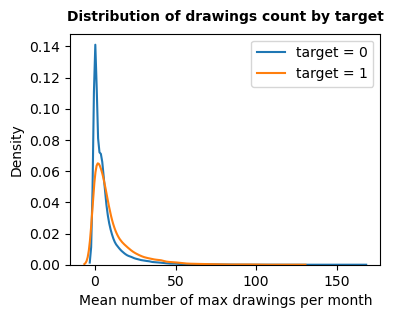

In [66]:
# Visualisation de la distribution de chaque target en fonction du nombre de retraits
# client_card_CNT_DRAWINGS_CURRENT_max_mean représente la moyenne par client du nombre max de retraits par mois 
# parmi tous les prêts contractés par le client 
fig = plt.figure(figsize = (4, 3))
sns.kdeplot(app_train.loc[app_train['TARGET'] == 0, 'client_card_CNT_DRAWINGS_CURRENT_max_mean'], 
            label = 'target = 0')
sns.kdeplot(app_train.loc[app_train['TARGET'] == 1, 'client_card_CNT_DRAWINGS_CURRENT_max_mean'], 
            label = 'target = 1')
plt.legend()
plt.xlabel('Mean number of max drawings per month')
plt.ylabel('Density')
plt.title('Distribution of drawings count by target', 
          fontsize = 10, y = 1.02, fontweight = 'bold')
fig.savefig('Représentation_graph/Drawings_distribution_by_target.png', 
            bbox_inches = "tight", transparent = True)

<span class="text-info">*Observations :*  
Il semble que moins le client effectue de retraits, plus il a tendance à rembourser le prêt dans les temps (target = 0), mais la corrélation est très faible.</span>

#### Effet de l'âge sur le remboursement d'un prêt

In [67]:
# Calcul de la valeur absolue 'DAYS_BIRTH' pour avoir l'âge réel positif
app_train['DAYS_BIRTH'] = abs(app_train['DAYS_BIRTH'])
app_train['DAYS_BIRTH'].corr(app_train['TARGET'])

-0.07823930830982709

<span class="text-info">*Observations :*  
Plus le client vieillit, plus le client a tendance à rembourser le prêt dans les temps (target = 0).</span>

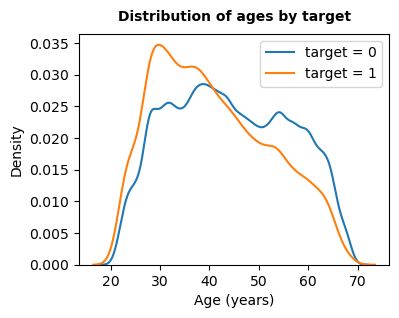

In [68]:
# Visualisation de la distribution de chaque target en fonction de l'âge
fig = plt.figure(figsize = (4, 3))
sns.kdeplot(app_train.loc[app_train['TARGET'] == 0, 'DAYS_BIRTH'] / 365, 
            label = 'target = 0')
sns.kdeplot(app_train.loc[app_train['TARGET'] == 1, 'DAYS_BIRTH'] / 365, 
            label = 'target = 1')
plt.legend()
plt.xlabel('Age (years)')
plt.ylabel('Density')
plt.title('Distribution of ages by target', 
          fontsize = 10, y = 1.02, fontweight = 'bold')
fig.savefig('Représentation_graph/Age_distribution_by_target.png', 
            bbox_inches = "tight", transparent = True)

<span class="text-info">*Observations :*  
Le graphique confirme la corrélation : il y a plus de prêts remboursés à temps après 40 ans, et moins avant 40 ans.</span>

In [69]:
# Création d'un dataframe séparé pour une étude plus approfondie
age_data = app_train[['TARGET', 'DAYS_BIRTH']]
age_data['YEARS_BIRTH'] = age_data['DAYS_BIRTH'] / 365

# Discrétisation de l'age en intervalles de 5 ans
age_data['YEARS_BINNED'] = pd.cut(age_data['YEARS_BIRTH'], 
                                  bins = np.linspace(20, 70, 
                                                     num = 11))
age_data.head(10)

,TARGET,DAYS_BIRTH,YEARS_BIRTH,YEARS_BINNED
0,1,9461,25.920548,"(25.0, 30.0]"
1,0,16765,45.931507,"(45.0, 50.0]"
2,0,19046,52.180822,"(50.0, 55.0]"
3,0,19005,52.068493,"(50.0, 55.0]"
4,0,19932,54.608219,"(50.0, 55.0]"
5,0,16941,46.413699,"(45.0, 50.0]"
6,0,13778,37.747945,"(35.0, 40.0]"
7,0,18850,51.643836,"(50.0, 55.0]"
8,0,20099,55.065753,"(55.0, 60.0]"
9,0,14469,39.641096,"(35.0, 40.0]"


In [70]:
# Regroupement par groupe d'âge pour calculer la moyenne par groupe
age_groups  = age_data.groupby('YEARS_BINNED').mean()
age_groups

,TARGET,DAYS_BIRTH,YEARS_BIRTH
YEARS_BINNED,,,
"(20.0, 25.0]",0.123036,8532.795625,23.377522
"(25.0, 30.0]",0.111436,10155.219250,27.822518
"(30.0, 35.0]",0.102814,11854.848377,32.479037
"(35.0, 40.0]",0.089414,13707.908253,37.555913
"(40.0, 45.0]",0.078491,15497.661233,42.459346
"(45.0, 50.0]",0.074171,17323.900441,47.462741
"(50.0, 55.0]",0.066968,19196.494791,52.593136
"(55.0, 60.0]",0.055314,20984.262742,57.491131
"(60.0, 65.0]",0.052737,22780.547460,62.412459


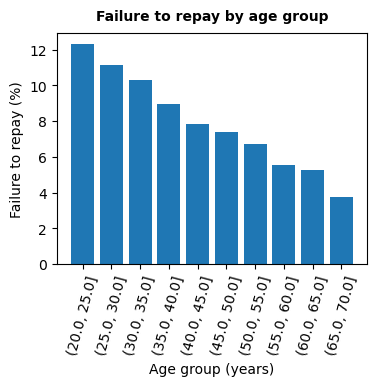

In [71]:
# Visualisation du taux de défaut de paiement en fonction de l'âge
fig = plt.figure(figsize = (4, 3))
plt.bar(age_groups.index.astype(str), 
        100 * age_groups['TARGET'])
plt.xticks(rotation = 75)
plt.xlabel('Age group (years)')
plt.ylabel('Failure to repay (%)')
plt.title('Failure to repay by age group', 
          fontsize = 10, y = 1.02, fontweight = 'bold')
fig.savefig('Représentation_graph/Failure_by_age_group.png', 
            bbox_inches = "tight", transparent = True)

#### Effet du nombre de jours en poste sur le remboursement d'un prêt

In [72]:
# Calcul de la valeur absolue 'DAYS_EMPLOYED' pour avoir le nombre de jours réel positif
app_train['DAYS_EMPLOYED'] = abs(app_train['DAYS_EMPLOYED'])
app_train['DAYS_EMPLOYED'].corr(app_train['TARGET'])

-0.07495845742543839

<span class="text-info">*Observations :*  
Plus le client est employé depuis longtemps, plus le client a tendance à rembourser le prêt dans les temps (target = 0).</span>

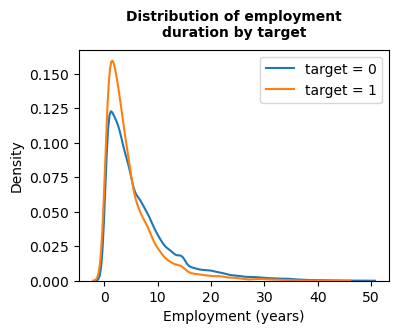

In [73]:
# Visualisation de la distribution de chaque target en fonction de l'âge
fig = plt.figure(figsize = (4, 3))
sns.kdeplot(app_train.loc[app_train['TARGET'] == 0, 'DAYS_EMPLOYED'] / 365, 
            label = 'target = 0')
sns.kdeplot(app_train.loc[app_train['TARGET'] == 1, 'DAYS_EMPLOYED'] / 365, 
            label = 'target = 1')
plt.legend()
plt.xlabel('Employment (years)')
plt.ylabel('Density')
plt.title('Distribution of employment\nduration by target', 
          fontsize = 10, y = 1.02, fontweight = 'bold')
fig.savefig('Représentation_graph/Employment_distribution_by_target.png', 
            bbox_inches = "tight", transparent = True)

<span class="text-info">*Observations :*  
Le graphique confirme la corrélation : il y a plus de prêts remboursés à temps lorsque le client est employé depuis longtemps.  
Malgré tout, l'écart reste très faible.</span>

In [74]:
# Création d'un dataframe séparé pour une étude plus approfondie
employment_data = app_train[['TARGET', 'DAYS_EMPLOYED']]
employment_data['YEARS_EMPLOYED'] = employment_data['DAYS_EMPLOYED'] / 365

# Discrétisation de l'age en intervalles de 5 ans
employment_data['YEARS_BINNED'] = pd.cut(employment_data['YEARS_EMPLOYED'], 
                                  bins = np.linspace(0, 50, 
                                                     num = 11))
employment_data.head(10)

,TARGET,DAYS_EMPLOYED,YEARS_EMPLOYED,YEARS_BINNED
0,1,637.0,1.745205,"(0.0, 5.0]"
1,0,1188.0,3.254795,"(0.0, 5.0]"
2,0,225.0,0.616438,"(0.0, 5.0]"
3,0,3039.0,8.326027,"(5.0, 10.0]"
4,0,3038.0,8.323288,"(5.0, 10.0]"
5,0,1588.0,4.350685,"(0.0, 5.0]"
6,0,3130.0,8.575342,"(5.0, 10.0]"
7,0,449.0,1.230137,"(0.0, 5.0]"
8,0,NaN,NaN,NaN
9,0,2019.0,5.531507,"(5.0, 10.0]"


In [75]:
# Regroupement par groupe d'âge pour calculer la moyenne par groupe
employment_groups  = employment_data.groupby('YEARS_BINNED').mean()
employment_groups

,TARGET,DAYS_EMPLOYED,YEARS_EMPLOYED
YEARS_BINNED,,,
"(0.0, 5.0]",0.105708,864.340763,2.368057
"(5.0, 10.0]",0.073714,2630.224689,7.206095
"(10.0, 15.0]",0.057752,4466.899670,12.238081
"(15.0, 20.0]",0.048484,6306.860448,17.279070
"(20.0, 25.0]",0.047573,8092.875701,22.172262
"(25.0, 30.0]",0.039903,9961.437122,27.291609
"(30.0, 35.0]",0.041258,11791.751418,32.306168
"(35.0, 40.0]",0.019231,13517.634615,37.034615
"(40.0, 45.0]",0.004762,15325.461905,41.987567


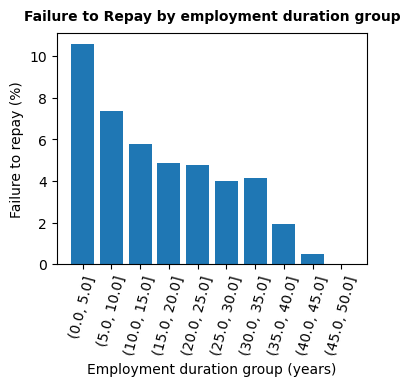

In [76]:
# Visualisation du taux de défaut de paiement en fonction de l'âge
fig = plt.figure(figsize = (4, 3))
plt.bar(employment_groups.index.astype(str), 
        100 * employment_groups['TARGET'])
plt.xticks(rotation = 75)
plt.xlabel('Employment duration group (years)')
plt.ylabel('Failure to repay (%)')
plt.title('Failure to Repay by employment duration group', 
          fontsize = 10, y = 1.02, fontweight = 'bold')
fig.savefig('Représentation_graph/Failure_by_employment_group.png', 
            bbox_inches = "tight", transparent = True)

#### Effets des sources extérieures

<span class="text-info">*Observations :*  
Les corrélations négatives les plus fortes sont 'EXT_SOURCE_1', 'EXT_SOURCE_2' et 'EXT_SOURCE_3'.  
Ces variables sont des scores normalisés provenant de sources externes.</span>

In [77]:
# Création d'un dataframe séparé pour une étude plus approfondie
ext_data = app_train[['TARGET', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH']]

# Calcul des corrélations
ext_data_corrs = ext_data.corr()
ext_data_corrs

,TARGET,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,DAYS_BIRTH
TARGET,1.000000,-0.155317,-0.160472,-0.178919,-0.078239
EXT_SOURCE_1,-0.155317,1.000000,0.213982,0.186846,0.600610
EXT_SOURCE_2,-0.160472,0.213982,1.000000,0.109167,0.091996
EXT_SOURCE_3,-0.178919,0.186846,0.109167,1.000000,0.205478
DAYS_BIRTH,-0.078239,0.600610,0.091996,0.205478,1.000000


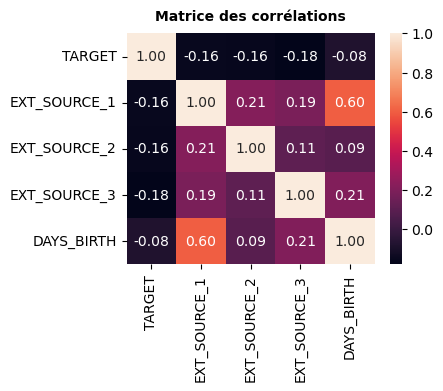

In [78]:
# Représentation via une heatmap
fig = plt.figure(figsize = (4, 3))
sns.heatmap(ext_data_corrs, annot = True, fmt = "0.2f")
plt.title('Matrice des corrélations', 
          fontsize = 10, y = 1.02, fontweight = 'bold') 
fig.savefig('Représentation_graph/Matrice_corrélation_EXT_SOURCE.png', 
            bbox_inches = "tight", transparent = True)

<span class="text-info">*Observations :*  
Les features 'EXT_SOURCE' sont toutes négatives, ce qui veut dire que plus leur valeur augmente, plus le client est supposé rembourser son prêt sans problème.  
Une plus grande corrélation existe entre 'EXT_SOURCE_1' et 'DAYS_BIRTH', ce qui laisse supposer qu'un des facteurs de 'EXT_SOURCE_1' est l'âge du client. </span>

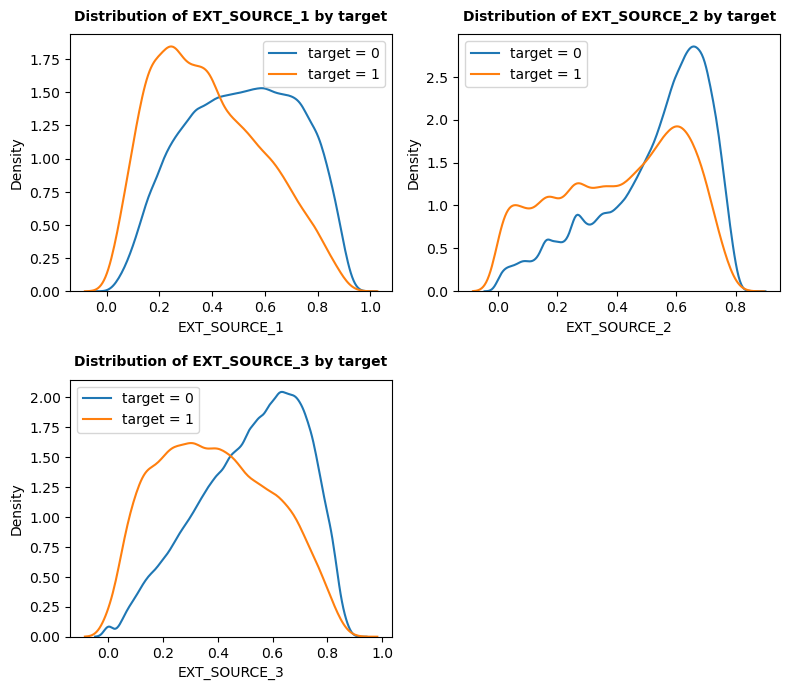

In [79]:
fig = plt.figure(figsize = (8, 7))
for i, source in enumerate(['EXT_SOURCE_1', 
                            'EXT_SOURCE_2', 
                            'EXT_SOURCE_3']):
    plt.subplot(2, 2, i + 1)
    sns.kdeplot(app_train.loc[app_train['TARGET'] == 0, source], 
                label = 'target = 0')
    sns.kdeplot(app_train.loc[app_train['TARGET'] == 1, source], 
                label = 'target = 1')
    plt.title('Distribution of %s by target' % source, 
              fontsize = 10, y = 1.02, fontweight = 'bold')
    plt.legend()
    plt.xlabel('%s' % source)
    plt.ylabel('Density')
plt.tight_layout(h_pad = 1.5)
fig.savefig('Représentation_graph/Distribution_EXT_SOURCE_by_target.png', 
            bbox_inches = "tight", transparent = True)

#### Retrait des variables corrélées entre elles

In [80]:
# Définition d'un seuil de colinéarité
threshold = 0.8

# Dictionnaire qui contiendra les variables corrélées
above_threshold_vars = {}

# Enregistrement des variables au dessus du seuil
for col in corr_matrix:
    above_threshold_vars[col] = list(corr_matrix.index[corr_matrix[col] > threshold])

In [81]:
# Enregistrement des colonnes à supprimer et colonnes déjà vues
cols_to_remove = []
cols_seen = []
cols_to_remove_pair = []

for key, value in above_threshold_vars.items():
    cols_seen.append(key)
    for x in value:
        if x == key:
            next
        else:
            if x not in cols_seen:
                cols_to_remove.append(x)
                cols_to_remove_pair.append(key)
            
cols_to_remove = list(set(cols_to_remove))
print('Number of columns to remove: ', len(cols_to_remove))

Number of columns to remove:  569


In [82]:
# Visualisation de format avant suppression des corrélations
print('Training Features shape: ', app_train.shape)
print('Testing Features shape: ', app_test.shape)

Training Features shape:  (307511, 1194)
Testing Features shape:  (48744, 1193)


In [83]:
# Suppression des variables corrélées entre elles
train_corrs_removed = app_train.drop(columns = cols_to_remove)
test_corrs_removed = app_test.drop(columns = cols_to_remove)

In [84]:
# Visualisation de format après suppression des corrélations
print('Training Features shape: ', train_corrs_removed.shape)
print('Testing Features shape: ', test_corrs_removed.shape)

Training Features shape:  (307511, 625)
Testing Features shape:  (48744, 624)


## FEATURE ENGINEERING
### Création de features polynomiales

In [85]:
# Création d'un nouveau dataframe avec les features polynomiales
# (utilisation de quelques features les plus corrélées et étudiées plus tôt)
poly_features = app_train[['EXT_SOURCE_1', 'EXT_SOURCE_2', 
                           'EXT_SOURCE_3', 'DAYS_BIRTH', 
                           'DAYS_EMPLOYED', 'TARGET']]
poly_features_test = app_test[['EXT_SOURCE_1', 'EXT_SOURCE_2', 
                               'EXT_SOURCE_3', 'DAYS_BIRTH', 
                               'DAYS_EMPLOYED']]

# Imputation des valeurs manquantes par la médiane
imputer = SimpleImputer(strategy = 'median')
poly_target = poly_features['TARGET']
poly_features = poly_features.drop(columns = ['TARGET'])
poly_features = imputer.fit_transform(poly_features)
poly_features_test = imputer.transform(poly_features_test)
                                  
# Création du transformer polynomial au degré 3
poly_transformer = PolynomialFeatures(degree = 3)

In [86]:
print('Features shape: ', poly_features.shape)

Features shape:  (307511, 5)


In [87]:
# Fitting du transformer sur les données
poly_transformer.fit(poly_features)

# Transformation des données
poly_features = poly_transformer.transform(poly_features)
poly_features_test = poly_transformer.transform(poly_features_test)
print('Polynomial Features shape: ', poly_features.shape)

Polynomial Features shape:  (307511, 56)


In [88]:
# Création d'un dataframe avec les nouvelles features + target
poly_features = pd.DataFrame(poly_features, 
                             columns = poly_transformer\
                                       .get_feature_names_out(['EXT_SOURCE_1', 
                                                               'EXT_SOURCE_2', 
                                                               'EXT_SOURCE_3', 
                                                               'DAYS_BIRTH', 
                                                               'DAYS_EMPLOYED']))

poly_features['TARGET'] = poly_target
poly_features_test = pd.DataFrame(poly_features_test, 
                                  columns = poly_transformer\
                                            .get_feature_names_out(['EXT_SOURCE_1', 
                                                                    'EXT_SOURCE_2', 
                                                                    'EXT_SOURCE_3', 
                                                                    'DAYS_BIRTH',
                                                                    'DAYS_EMPLOYED']))

# Calcul des corrélations avec la target
poly_corrs = poly_features.corr()['TARGET'].sort_values()

# Affichage des corrélations les plus fortes (négatives ou positives)
print('Most Positive Correlations:\n', poly_corrs.tail(5))
print('\nMost Negative Correlations:\n', poly_corrs.head(10))

Most Positive Correlations:
 DAYS_EMPLOYED^2              -0.046234
DAYS_BIRTH DAYS_EMPLOYED^2   -0.045008
DAYS_EMPLOYED^3              -0.035229
TARGET                        1.000000
1                                  NaN
Name: TARGET, dtype: float64

Most Negative Correlations:
 EXT_SOURCE_2 EXT_SOURCE_3                -0.193939
EXT_SOURCE_1 EXT_SOURCE_2 EXT_SOURCE_3   -0.189605
EXT_SOURCE_2 EXT_SOURCE_3 DAYS_BIRTH     -0.181283
EXT_SOURCE_2^2 EXT_SOURCE_3              -0.176428
EXT_SOURCE_2 EXT_SOURCE_3^2              -0.172282
EXT_SOURCE_1 EXT_SOURCE_2                -0.166625
EXT_SOURCE_1 EXT_SOURCE_3                -0.164065
EXT_SOURCE_2                             -0.160295
EXT_SOURCE_2 DAYS_BIRTH                  -0.156873
EXT_SOURCE_1 EXT_SOURCE_2^2              -0.156867
Name: TARGET, dtype: float64


<span class="text-info">*Observations :*  
Quelques features polynomiales possèdent une corrélation plus grande (en valeur absolue) avec la target.  
Elles pourront être utilisées lors de la modélisation.</span>

In [89]:
# Fusion des nouvelles features avec les données initiales
poly_features['SK_ID_CURR'] = app_train['SK_ID_CURR']
poly_features = poly_features.drop(columns = ['EXT_SOURCE_1', 
                                              'EXT_SOURCE_2', 
                                              'EXT_SOURCE_3', 
                                              'DAYS_BIRTH',
                                              'DAYS_EMPLOYED'])

app_train_poly = app_train.merge(poly_features, on = 'SK_ID_CURR', 
                                 how = 'left')
train_corrs_removed_poly = train_corrs_removed.merge(poly_features, 
                                                     on = 'SK_ID_CURR', 
                                                     how = 'left')
poly_features_test['SK_ID_CURR'] = app_test['SK_ID_CURR']
app_test_poly = app_test.merge(poly_features_test, on = 'SK_ID_CURR', 
                               how = 'left')
test_corrs_removed_poly = test_corrs_removed.merge(poly_features_test, 
                                                   on = 'SK_ID_CURR', 
                                                   how = 'left')

# Alignement du training and testing set 
# en ne gardant que les colonnes présentes dans les 2 dataframes
app_train_poly, app_test_poly = app_train_poly.align(app_test_poly, 
                                                     join = 'inner', 
                                                     axis = 1)
train_corrs_removed_poly, test_corrs_removed_poly = train_corrs_removed_poly.align(test_corrs_removed_poly, 
                                                                                   join = 'inner', 
                                                                                   axis = 1)
app_train_poly['TARGET'] = poly_target
train_corrs_removed_poly['TARGET'] = poly_target


# Visualisation du nouveau nombre de lignes/colonnes
print('Training data with polynomial features shape: ', 
      app_train_poly.shape)
print('Testing data with polynomial features shape:  ', 
      app_test_poly.shape)
print('Training data with polynomial features and corrs removed shape: ', 
      train_corrs_removed_poly.shape)
print('Testing data with polynomial features and corrs removed shape:  ', 
      test_corrs_removed_poly.shape)

Training data with polynomial features shape:  (307511, 1240)
Testing data with polynomial features shape:   (48744, 1239)
Training data with polynomial features and corrs removed shape:  (307511, 671)
Testing data with polynomial features and corrs removed shape:   (48744, 670)


### Création de features via les connaissances métier

Nous allons créer quelques features qui semblent importantes lors de l'attribution d'un prêt : 
- 'DEBT_RATIO' : le pourcentage du crédit souscrit relatif aux revenus d'un client ;
- 'ANNUITY_INCOME_RATIO' : taux d'endettement (chez Home Credit), le pourcentage des mensualités Home Credit relatif aux revenus d'un client ;
- 'CREDIT_TERM' : la durée du prêt en mois ;
- 'EMPLOYMENT_AGE_RATIO' : le pourcentage de jours travaillés relatif à l'âge du client.

In [90]:
# Création des variables pour le jeu d'entrainement
# Avec les corrélations
app_train_domain = app_train.copy()
app_train_domain['DEBT_RATIO'] = app_train_domain['AMT_CREDIT'] / app_train_domain['AMT_INCOME_TOTAL']
app_train_domain['ANNUITY_INCOME_RATIO'] = app_train_domain['AMT_ANNUITY'] / app_train_domain['AMT_INCOME_TOTAL']
app_train_domain['CREDIT_TERM'] = app_train_domain['AMT_ANNUITY'] / app_train_domain['AMT_CREDIT']
app_train_domain['DAYS_EMPLOYED_RATIO'] = app_train_domain['DAYS_EMPLOYED'] / app_train_domain['DAYS_BIRTH']

# Sans les variables corrélées entre elles
train_corrs_removed_domain = train_corrs_removed.copy()
train_corrs_removed_domain['DEBT_RATIO'] = train_corrs_removed_domain['AMT_CREDIT'] / train_corrs_removed_domain['AMT_INCOME_TOTAL']
train_corrs_removed_domain['ANNUITY_INCOME_RATIO'] = train_corrs_removed_domain['AMT_ANNUITY'] / train_corrs_removed_domain['AMT_INCOME_TOTAL']
train_corrs_removed_domain['CREDIT_TERM'] = train_corrs_removed_domain['AMT_ANNUITY'] / train_corrs_removed_domain['AMT_CREDIT']
train_corrs_removed_domain['DAYS_EMPLOYED_RATIO'] = train_corrs_removed_domain['DAYS_EMPLOYED'] / train_corrs_removed_domain['DAYS_BIRTH']

# Création des variables pour le jeu de test
# Avec les corrélations
app_test_domain = app_test.copy()
app_test_domain['DEBT_RATIO'] = app_test_domain['AMT_CREDIT'] / app_test_domain['AMT_INCOME_TOTAL']
app_test_domain['ANNUITY_INCOME_RATIO'] = app_test_domain['AMT_ANNUITY'] / app_test_domain['AMT_INCOME_TOTAL']
app_test_domain['CREDIT_TERM'] = app_test_domain['AMT_ANNUITY'] / app_test_domain['AMT_CREDIT']
app_test_domain['DAYS_EMPLOYED_RATIO'] = app_test_domain['DAYS_EMPLOYED'] / app_test_domain['DAYS_BIRTH']

In [91]:
# Sans les variables corrélées entre elles
test_corrs_removed_domain = test_corrs_removed.copy()
test_corrs_removed_domain['DEBT_RATIO'] = test_corrs_removed_domain['AMT_CREDIT'] / test_corrs_removed_domain['AMT_INCOME_TOTAL']
test_corrs_removed_domain['ANNUITY_INCOME_RATIO'] = test_corrs_removed_domain['AMT_ANNUITY'] / test_corrs_removed_domain['AMT_INCOME_TOTAL']
test_corrs_removed_domain['CREDIT_TERM'] = test_corrs_removed_domain['AMT_ANNUITY'] / test_corrs_removed_domain['AMT_CREDIT']
test_corrs_removed_domain['DAYS_EMPLOYED_RATIO'] = test_corrs_removed_domain['DAYS_EMPLOYED'] / test_corrs_removed_domain['DAYS_BIRTH']

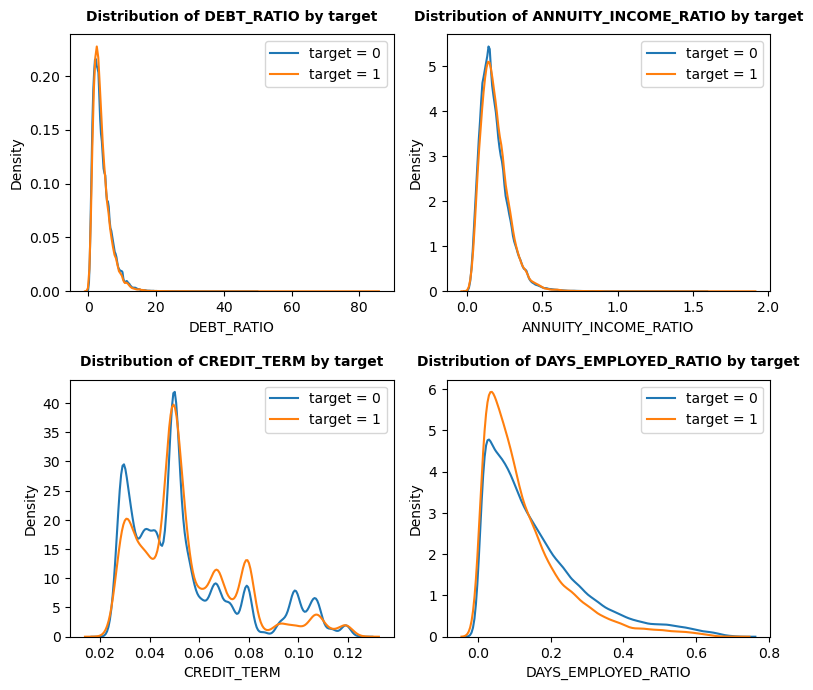

In [92]:
# Visualisation des nouvelles features via kdeplot
fig = plt.figure(figsize = (8, 7))
for i, source in enumerate(['DEBT_RATIO', 
                            'ANNUITY_INCOME_RATIO', 
                            'CREDIT_TERM',
                            'DAYS_EMPLOYED_RATIO']):
    plt.subplot(2, 2, i + 1)
    sns.kdeplot(app_train_domain.loc[app_train_domain['TARGET'] == 0, source], 
                label = 'target = 0')
    sns.kdeplot(app_train_domain.loc[app_train_domain['TARGET'] == 1, source], 
                label = 'target = 1')
    plt.title('Distribution of %s by target' % source, 
              fontsize = 10, y = 1.02, fontweight = 'bold')
    plt.legend()
    plt.xlabel('%s' % source)
    plt.ylabel('Density')
plt.tight_layout(h_pad = 1.5)
fig.savefig('Représentation_graph/Distribution_new_features_by_target.png', 
            bbox_inches = "tight", transparent = True)

<span class="text-info">*Observations :*  
Les distributions de ces features semblent similaires pour les 2 modalités de la target.
L'utilité de ces features sera testée lors de la modélisation.</span>

## ENREGISTREMENT DES DONNEES

In [93]:
# Enregistrement des différents jeux de données d'entrainement créés 
# app_train avec traitement des anomalies
app_train.to_csv('app_train_cleaned.csv', index = False) 
# app_train avec traitement des anomalies + colinéarités retirées
train_corrs_removed.to_csv('train_corrs_removed.csv', index = False) 
# app_train avec traitement des anomalies + colinéarités retirées + feature engineering polynomial
train_corrs_removed_poly.to_csv('train_corrs_removed_poly.csv', index = False)
# app_train avec traitement des anomalies + feature engineering polynomial
app_train_poly.to_csv('app_train_poly.csv', index = False)
# app_train avec traitement des anomalies + feature engineering métier
app_train_domain.to_csv('app_train_domain.csv', index = False)
# app_train avec traitement des anomalies + colinéarités retirées + feature engineering métier
train_corrs_removed_domain.to_csv('train_corrs_removed_domain.csv', index = False)

## MODELISATIONS

<span class="text-info">*Métriques utilisées pour évaluer les modèles :*  
<span class="text-info">- accuracy : proportion de points correctement prédits (peut être faussée si utilisation d'un jeu de donnée déséquilibré comme dans notre cas) ;  
<span class="text-info">- precision : proportion de points positifs correctement prédits parmi les points que l’on a prédits positifs (= TP/(TP+FP)) ;  
<span class="text-info">- recall : proportion de points positifs correctement prédits parmi les points réellement positifs (=TP/(TP+FN)) ;  
<span class="text-info">- F1-score : moyenne harmonique entre la précision et le recall (= 2×(precision×rappel)/(precision+rappel) = 2TP/(2TP+FP+FN)) ;  
<span class="text-info">- F2-score : F2 = 5×(precision×rappel)/(4×precision+rappel) ce qui donne plus de poids à la précision que pour le F1-score ;  
<span class="text-info">- AUC_ROC : la courbe ROC représente les taux de TP (recall) et de FP (= FP/(FP/TN)) pour différents seuils de classification. AUC mesure l'aire sous la courbe. Un modèle dont les prédictions sont totalement fausses a un AUC de 0,0. Un modèle dont les prédictions sont correctes a un AUC de 1,0. L'AUC est indépendante des seuils de classification (or nous allons jouer sur les seuils de classification pour limiter au maximum les FN donc ne sera pas utiles sur tous les modèles...). </span>
    
Commençons les modélisations avec le dataset cleané sans les corrélations enlevées et la création de nouvelles features :

In [94]:
# Chargement du dataset cleané pour modélisation
app_train_cleaned = pd.read_csv('app_train_cleaned.csv')

In [95]:
# Initialisation de la liste qui contiendra les résultats de chaque modèle à l'aide de la fonction scores()
results = []

In [96]:
# Suppression de la target
app_train_target = app_train_cleaned['TARGET']
app_train_cleaned = app_train_cleaned.drop(columns = ['SK_ID_CURR', 'TARGET'])

In [97]:
features = app_train_cleaned.columns

In [98]:
# Imputation des valeurs manquantes par la médiane
imputer = SimpleImputer(strategy = 'median')
imputer.fit(app_train_cleaned)
app_train_cleaned = imputer.transform(app_train_cleaned)

In [99]:
# Splitting du jeu train en train+val
train, val, train_labels, val_labels = train_test_split(app_train_cleaned, 
                                                        app_train_target, 
                                                        test_size = 0.2, 
                                                        stratify = app_train_target,
                                                        random_state = 56)

In [100]:
print('Training shape: ', train.shape)
print('Validation shape: ', val.shape)

Training shape:  (246008, 1192)
Validation shape:  (61503, 1192)


### Baseline : DummyClassifier

In [101]:
# Création du classifieur
dummy_clf = DummyClassifier(strategy = "stratified")

Results on validation set:
Accuracy score:    0.854
Precision score:   0.0813
Recall score:      0.0788
F1 score:          0.08
F2 score:          0.079
ROCAUC score:      0.5


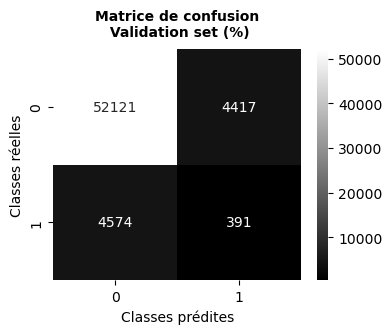

,classifier,TN_val,FP_val,FN_val,TP_val,cost,train_accuracy,val_accuracy,train_precision,val_precision,train_recall,val_recall,train_F1_score,val_F1_score,train_F2_score,val_F2_score,train_roc_auc,val_roc_auc,train_time,predict_time
0,Dummy,52121,4417,4574,391,50157,0.851436,0.853812,0.08255,0.081323,0.083082,0.078751,0.082815,0.080016,0.082975,0.079252,0.500997,0.500313,0.006616,0.001636


In [102]:
# Calcul des différents scores et compilation des scores du modèle dans un dataframe
scores('Dummy', dummy_clf, train, val, 
       train_labels, val_labels, results)

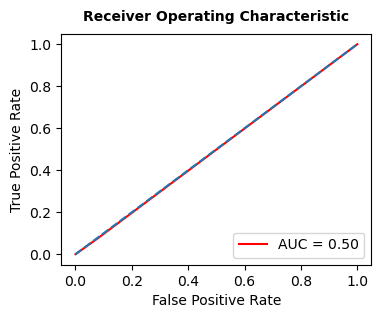

In [103]:
# Représentation graphique de la ROC_curve
ROC_curve('Dummy', dummy_clf, val, val_labels)

<span class="text-info">*Observations :*  
Nous obtenons une ROC_AUC de 0,5, comme attendu, l'algorithme Dummy n'est pas informatif. 

### Régression logistique

In [104]:
# Création du classifieur
log_reg = LogisticRegression(C = 0.0001)

Results on validation set:
Accuracy score:    0.919
Precision score:   0.136
Recall score:      0.000604
F1 score:          0.0012
F2 score:          0.00075
ROCAUC score:      0.592


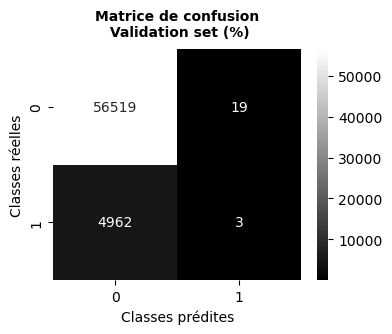

,classifier,TN_val,FP_val,FN_val,TP_val,cost,train_accuracy,val_accuracy,train_precision,val_precision,train_recall,val_recall,train_F1_score,val_F1_score,train_F2_score,val_F2_score,train_roc_auc,val_roc_auc,train_time,predict_time
0,Dummy,52121,4417,4574,391,50157,0.851436,0.853812,0.082550,0.081323,0.083082,0.078751,0.082815,0.080016,0.082975,0.079252,0.500997,0.500313,0.006616,0.001636
1,Logistic regression,56519,19,4962,3,49639,0.919060,0.919012,0.197674,0.136364,0.000856,0.000604,0.001705,0.001203,0.001069,0.000754,0.597383,0.591832,20.659498,0.025115


In [105]:
# Calcul des différents scores et compilation des scores du modèle dans un dataframe
scores('Logistic regression', log_reg, train, val, 
       train_labels, val_labels, results)

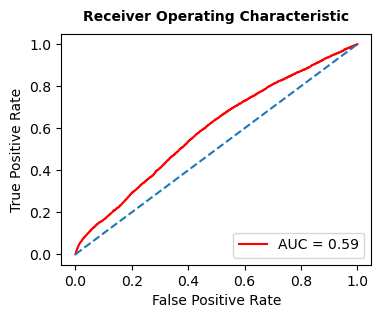

In [106]:
# Représentation graphique de la ROC_curve
ROC_curve('Logistic regression', log_reg, val, val_labels)

<span class="text-info">*Observations :*  
La ROC_AUC est légèrement supérieure à celle du classifieur Dummy.  
Néanmois, elle reste faible et beaucoup de FN sont prédits par rapport aux FP, or nous souhaitons limiter les FN.

### LightGBM
#### LightGBM simple sans équilibrage de la target

In [107]:
# Création du modèle 
lgb_simple = lgb.LGBMClassifier(objective = 'binary', 
                               boosting_type = 'goss', 
                               n_estimators = 10000, 
                               class_weight = None)

[100]	training's auc: 0.831161	training's binary_logloss: 0.220742	valid_1's auc: 0.773491	valid_1's binary_logloss: 0.242001
[200]	training's auc: 0.871346	training's binary_logloss: 0.203494	valid_1's auc: 0.773474	valid_1's binary_logloss: 0.242329
[300]	training's auc: 0.900165	training's binary_logloss: 0.189432	valid_1's auc: 0.771188	valid_1's binary_logloss: 0.243347
Results on validation set:
Accuracy score:    0.919
Precision score:   0.516
Recall score:      0.0417
F1 score:          0.0772
F2 score:          0.051
ROCAUC score:      0.774


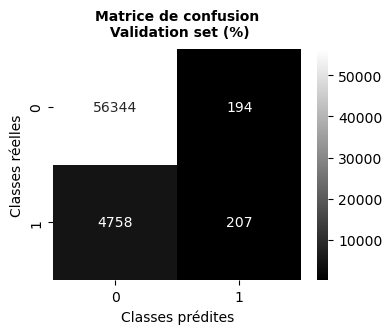

,classifier,TN_val,FP_val,FN_val,TP_val,cost,train_accuracy,val_accuracy,train_precision,val_precision,train_recall,val_recall,train_F1_score,val_F1_score,train_F2_score,val_F2_score,train_roc_auc,val_roc_auc,train_time,predict_time
0,Dummy,52121,4417,4574,391,50157,0.851436,0.853812,0.082550,0.081323,0.083082,0.078751,0.082815,0.080016,0.082975,0.079252,0.500997,0.500313,0.006616,0.001636
1,Logistic regression,56519,19,4962,3,49639,0.919060,0.919012,0.197674,0.136364,0.000856,0.000604,0.001705,0.001203,0.001069,0.000754,0.597383,0.591832,20.659498,0.025115
2,LightGBM,56344,194,4758,207,47774,0.923059,0.919484,0.779042,0.516209,0.065509,0.041692,0.120855,0.077152,0.080200,0.051083,0.836274,0.773890,34.421287,0.109799


In [108]:
# Calcul des différents scores et compilation des scores du modèle dans un dataframe
scores('LightGBM', lgb_simple, train, val, 
        train_labels, val_labels, results, 
        fit_params = {'early_stopping_rounds': 200, 
                      'eval_set': [(train, train_labels), (val, val_labels)], 
                      'eval_metric': 'auc', 
                      'verbose': 100})

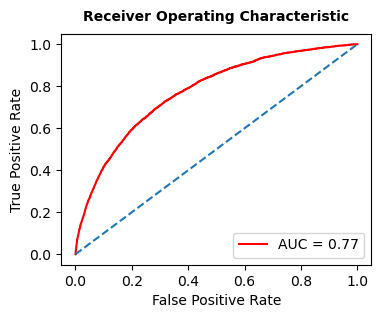

In [109]:
# Représentation graphique de la ROC_curve
ROC_curve('LightGBM', lgb_simple, val, val_labels)

<span class="text-info">*Observations :*  
Nous remarquons qu'à cause de jeu de données non équilibré, la plupart des prédictions sont négatives (classe 0).  
Nous avons par conséquent beaucoup de FN. Nous allons maintenant essayer des méthodes de ré-équilibrage de la target.

#### Equilibrage de la target
##### Méthode n°1 : class_weight de LGBMClassifier

In [110]:
# Création du modèle 
lgb_balanced = lgb.LGBMClassifier(objective = 'binary', 
                                  boosting_type = 'goss', 
                                  n_estimators = 10000, 
                                  class_weight = 'balanced')

[100]	training's auc: 0.828148	training's binary_logloss: 0.516535	valid_1's auc: 0.777366	valid_1's binary_logloss: 0.538491
[200]	training's auc: 0.865028	training's binary_logloss: 0.473614	valid_1's auc: 0.778217	valid_1's binary_logloss: 0.511973
[300]	training's auc: 0.892499	training's binary_logloss: 0.43922	valid_1's auc: 0.778285	valid_1's binary_logloss: 0.490362
Results on validation set:
Accuracy score:    0.737
Precision score:   0.187
Recall score:      0.672
F1 score:          0.292
F2 score:          0.44
ROCAUC score:      0.779


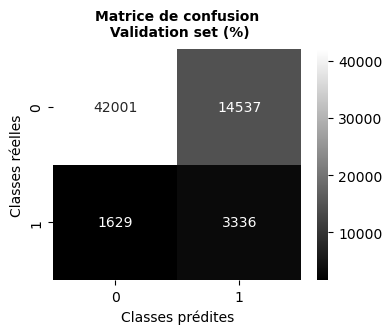

,classifier,TN_val,FP_val,FN_val,TP_val,cost,train_accuracy,val_accuracy,train_precision,val_precision,train_recall,val_recall,train_F1_score,val_F1_score,train_F2_score,val_F2_score,train_roc_auc,val_roc_auc,train_time,predict_time
0,Dummy,52121,4417,4574,391,50157,0.851436,0.853812,0.082550,0.081323,0.083082,0.078751,0.082815,0.080016,0.082975,0.079252,0.500997,0.500313,0.006616,0.001636
1,Logistic regression,56519,19,4962,3,49639,0.919060,0.919012,0.197674,0.136364,0.000856,0.000604,0.001705,0.001203,0.001069,0.000754,0.597383,0.591832,20.659498,0.025115
2,LightGBM,56344,194,4758,207,47774,0.923059,0.919484,0.779042,0.516209,0.065509,0.041692,0.120855,0.077152,0.080200,0.051083,0.836274,0.773890,34.421287,0.109799
3,LightGBM_balanced,42001,14537,1629,3336,30827,0.754077,0.737151,0.216133,0.186650,0.779003,0.671903,0.338382,0.292145,0.512214,0.442053,0.846455,0.778751,34.627094,0.137321


In [111]:
# Calcul des différents scores et compilation des scores du modèle dans un dataframe
scores('LightGBM_balanced', lgb_balanced, train, val, 
        train_labels, val_labels, results, 
        fit_params = {'early_stopping_rounds': 200, 
                      'eval_set': [(train, train_labels), (val, val_labels)], 
                      'eval_metric': 'auc', 
                      'verbose': 100})

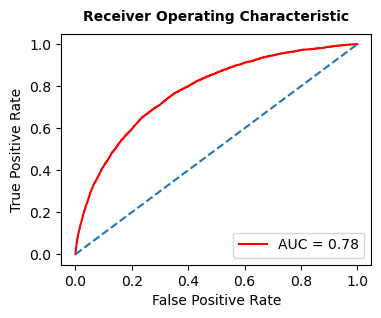

In [112]:
# Représentation graphique de la ROC_curve
ROC_curve('LightGBM_balanced', lgb_balanced, val, val_labels)

<span class="text-info">*Observations :*  
Nous observons une nette diminution du nombre de FN.

##### Méthode n°2 : under-sampling de la librairie Imbalanced-Learn

Nous allons tester plusieurs stratégies de sampling :  
1 . sampling_strategy = 'majority'

In [113]:
# Définition de la stratégie d'undersampling
undersample = RandomUnderSampler(sampling_strategy = 'majority')

In [114]:
# Fitting et sampling sur le jeu d'entrainement
train_under, train_labels_under = undersample.fit_resample(train, 
                                                           train_labels)

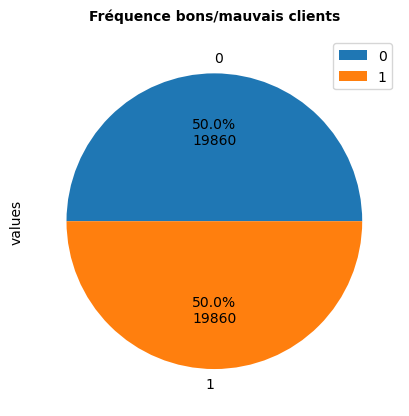

In [115]:
# Visualisation graphique via piechart
tmp = train_labels_under.value_counts()
df = pd.DataFrame({'labels': tmp.index,
                   'values': tmp.values})

total = df['values'].sum()
def fmt(x):
    return '{:.1f}%\n{:.0f}'.format(x, total*x/100)

df.plot(kind = 'pie', y = 'values', autopct = fmt)
ax = plt.title('Fréquence bons/mauvais clients', fontsize = 10, 
               y = 1.02, fontweight = 'bold')

In [116]:
# Création du modèle 
lgb_under_maj = lgb.LGBMClassifier(objective = 'binary', 
                               boosting_type = 'goss', 
                               n_estimators = 10000, 
                               class_weight = None)

[100]	valid_0's auc: 0.806456	valid_0's binary_logloss: 0.570061	valid_1's auc: 0.762476	valid_1's binary_logloss: 0.583964
[200]	valid_0's auc: 0.829118	valid_0's binary_logloss: 0.569883	valid_1's auc: 0.754532	valid_1's binary_logloss: 0.596054
Results on validation set:
Accuracy score:    0.693
Precision score:   0.167
Recall score:      0.702
F1 score:          0.269
F2 score:          0.43
ROCAUC score:      0.763


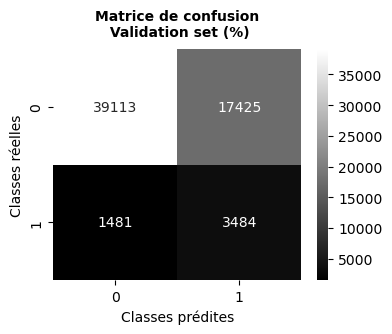

,classifier,TN_val,FP_val,FN_val,TP_val,cost,train_accuracy,val_accuracy,train_precision,val_precision,train_recall,val_recall,train_F1_score,val_F1_score,train_F2_score,val_F2_score,train_roc_auc,val_roc_auc,train_time,predict_time
0,Dummy,52121,4417,4574,391,50157,0.851436,0.853812,0.082550,0.081323,0.083082,0.078751,0.082815,0.080016,0.082975,0.079252,0.500997,0.500313,0.006616,0.001636
1,Logistic regression,56519,19,4962,3,49639,0.919060,0.919012,0.197674,0.136364,0.000856,0.000604,0.001705,0.001203,0.001069,0.000754,0.597383,0.591832,20.659498,0.025115
2,LightGBM,56344,194,4758,207,47774,0.923059,0.919484,0.779042,0.516209,0.065509,0.041692,0.120855,0.077152,0.080200,0.051083,0.836274,0.773890,34.421287,0.109799
3,LightGBM_balanced,42001,14537,1629,3336,30827,0.754077,0.737151,0.216133,0.186650,0.779003,0.671903,0.338382,0.292145,0.512214,0.442053,0.846455,0.778751,34.627094,0.137321
4,LightGBM_under_maj,39113,17425,1481,3484,32235,0.735524,0.692600,0.732769,0.166627,0.741440,0.701712,0.737079,0.269305,0.739690,0.427285,0.814627,0.762605,12.696022,0.074160


In [117]:
# Calcul des différents scores et compilation des scores du modèle dans un dataframe
scores('LightGBM_under_maj', lgb_under_maj, train_under, val, 
        train_labels_under, val_labels, results, 
        fit_params = {'early_stopping_rounds': 200, 
                      'eval_set': [(train, train_labels), (val, val_labels)], 
                      'eval_metric': 'auc', 
                      'verbose': 100})

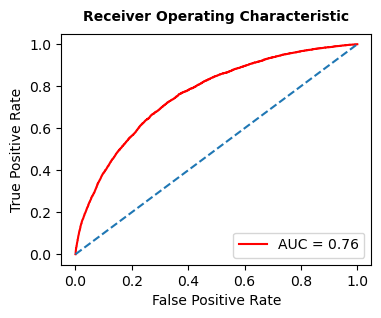

In [118]:
# Représentation graphique de la ROC_curve
ROC_curve('LightGBM_under', lgb_under_maj, val, val_labels)

<span class="text-info">*Observations :*  
Nous avons à nouveau une diminution du nombre de FN, mais une augmentation non négligeable du nombre de FP.

2. sampling_strategy = 0.2, 0.4, 0.6 et 0.8

[100]	valid_0's auc: 0.817764	valid_0's binary_logloss: 0.255161	valid_1's auc: 0.759483	valid_1's binary_logloss: 0.274615
[200]	valid_0's auc: 0.850393	valid_0's binary_logloss: 0.243474	valid_1's auc: 0.754337	valid_1's binary_logloss: 0.279009
Results on validation set:
Accuracy score:    0.909
Precision score:   0.358
Recall score:      0.153
F1 score:          0.215
F2 score:          0.17
ROCAUC score:      0.761


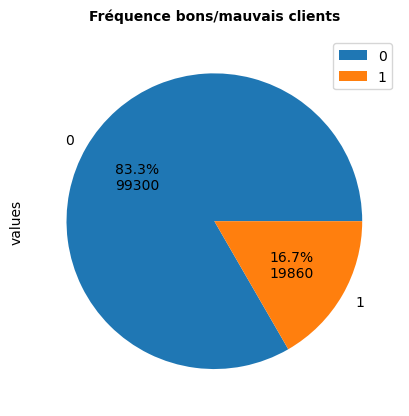

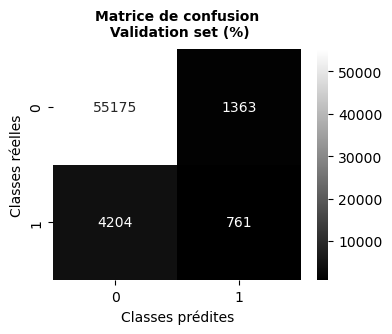

[100]	valid_0's auc: 0.812849	valid_0's binary_logloss: 0.337271	valid_1's auc: 0.760575	valid_1's binary_logloss: 0.353857
[200]	valid_0's auc: 0.839108	valid_0's binary_logloss: 0.331339	valid_1's auc: 0.755202	valid_1's binary_logloss: 0.362147
Results on validation set:
Accuracy score:    0.868
Precision score:   0.262
Recall score:      0.352
F1 score:          0.3
F2 score:          0.33
ROCAUC score:      0.762


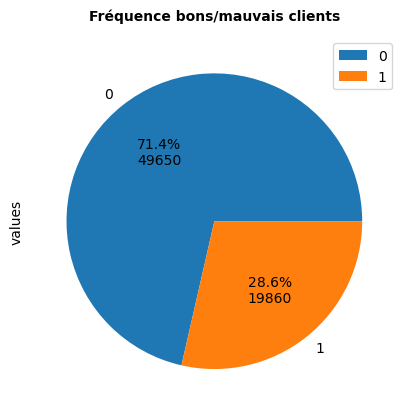

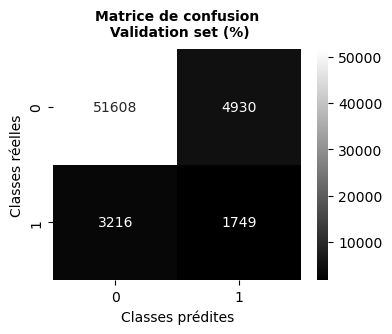

[100]	valid_0's auc: 0.810491	valid_0's binary_logloss: 0.420948	valid_1's auc: 0.763186	valid_1's binary_logloss: 0.436067
[200]	valid_0's auc: 0.835419	valid_0's binary_logloss: 0.415327	valid_1's auc: 0.758992	valid_1's binary_logloss: 0.44327
Results on validation set:
Accuracy score:    0.811
Precision score:   0.219
Recall score:      0.52
F1 score:          0.308
F2 score:          0.41
ROCAUC score:      0.764


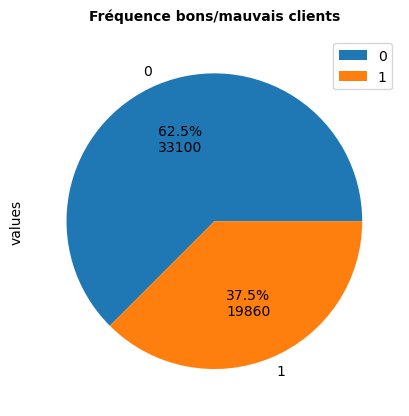

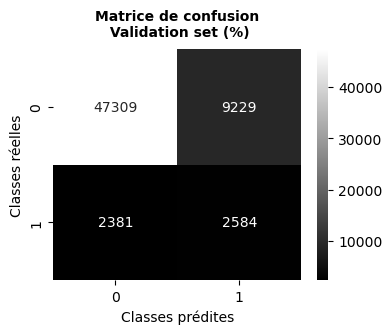

[100]	valid_0's auc: 0.80984	valid_0's binary_logloss: 0.494183	valid_1's auc: 0.762858	valid_1's binary_logloss: 0.508265
[200]	valid_0's auc: 0.834314	valid_0's binary_logloss: 0.489119	valid_1's auc: 0.757031	valid_1's binary_logloss: 0.514577
Results on validation set:
Accuracy score:    0.755
Precision score:   0.189
Recall score:      0.622
F1 score:          0.29
F2 score:          0.43
ROCAUC score:      0.764


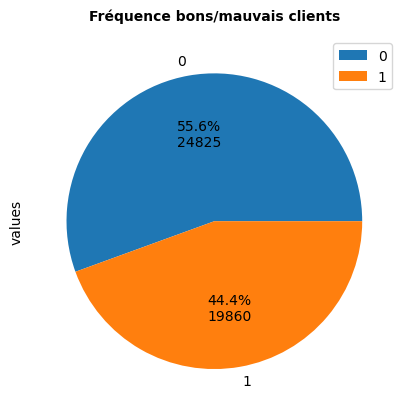

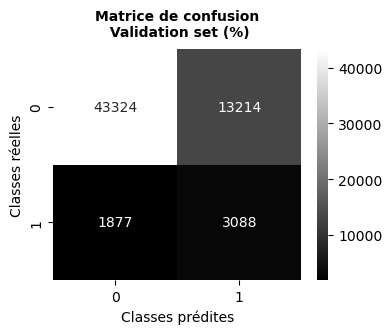

In [119]:
for i, sampling_strat in enumerate([0.2, 0.4, 0.6, 0.8]):
    # Définition de la stratégie d'undersampling
    undersample = RandomUnderSampler(sampling_strategy = sampling_strat)
    # Fitting et sampling sur le jeu d'entrainement
    train_under, train_labels_under = undersample.fit_resample(train, 
                                                               train_labels)
    
    # Visualisation graphique via piechart
    tmp = train_labels_under.value_counts()
    df = pd.DataFrame({'labels': tmp.index,
                       'values': tmp.values})
    total = df['values'].sum()
    df.plot(kind = 'pie', y = 'values', autopct = fmt)
    ax = plt.title('Fréquence bons/mauvais clients', fontsize = 10, 
                   y = 1.02, fontweight = 'bold')
    
    # Création du modèle 
    lgb_under = lgb.LGBMClassifier(objective = 'binary', 
                                   boosting_type = 'goss', 
                                   n_estimators = 10000, 
                                   class_weight = None)
    # Calcul des différents scores et compilation des scores du modèle dans un dataframe
    scores(f'LightGBM_under_0.{(i+1)*2}', lgb_under, train_under, val, 
        train_labels_under, val_labels, results, 
        fit_params = {'early_stopping_rounds': 200, 
                      'eval_set': [(train, train_labels), (val, val_labels)], 
                      'eval_metric': 'auc', 
                      'verbose': 100})

<span class="text-info">*Observations :*  
Cette méthode ne donne pas de meilleurs résultats en termes de nombre de FN/FP.

2. sampling_strategy = 0.2, 0.4, 0.6 et 0.8 + class_weight = 'balanced'

[100]	valid_0's auc: 0.818002	valid_0's binary_logloss: 0.524324	valid_1's auc: 0.769828	valid_1's binary_logloss: 0.539131
[200]	valid_0's auc: 0.849157	valid_0's binary_logloss: 0.495623	valid_1's auc: 0.768191	valid_1's binary_logloss: 0.523635
Results on validation set:
Accuracy score:    0.729
Precision score:   0.181
Recall score:      0.668
F1 score:          0.285
F2 score:          0.43
ROCAUC score:      0.771


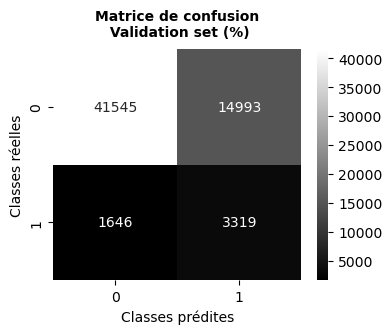

[100]	valid_0's auc: 0.815104	valid_0's binary_logloss: 0.536357	valid_1's auc: 0.766412	valid_1's binary_logloss: 0.550319
[200]	valid_0's auc: 0.842897	valid_0's binary_logloss: 0.515925	valid_1's auc: 0.760492	valid_1's binary_logloss: 0.543442
Results on validation set:
Accuracy score:    0.721
Precision score:   0.177
Recall score:      0.674
F1 score:          0.28
F2 score:          0.43
ROCAUC score:      0.767


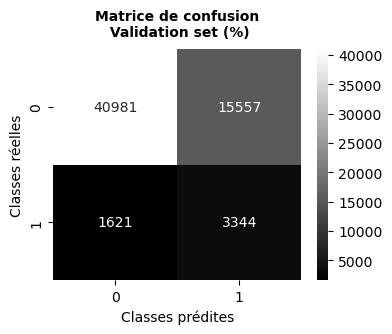

[100]	valid_0's auc: 0.812008	valid_0's binary_logloss: 0.547556	valid_1's auc: 0.764491	valid_1's binary_logloss: 0.563144
[200]	valid_0's auc: 0.838957	valid_0's binary_logloss: 0.533038	valid_1's auc: 0.758871	valid_1's binary_logloss: 0.56064
Results on validation set:
Accuracy score:    0.71
Precision score:   0.174
Recall score:      0.69
F1 score:          0.277
F2 score:          0.43
ROCAUC score:      0.765


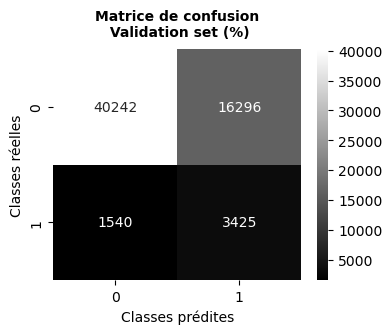

[100]	valid_0's auc: 0.809538	valid_0's binary_logloss: 0.558049	valid_1's auc: 0.762557	valid_1's binary_logloss: 0.573114
[200]	valid_0's auc: 0.83333	valid_0's binary_logloss: 0.552639	valid_1's auc: 0.756152	valid_1's binary_logloss: 0.5807
Results on validation set:
Accuracy score:    0.705
Precision score:   0.171
Recall score:      0.687
F1 score:          0.273
F2 score:          0.43
ROCAUC score:      0.764


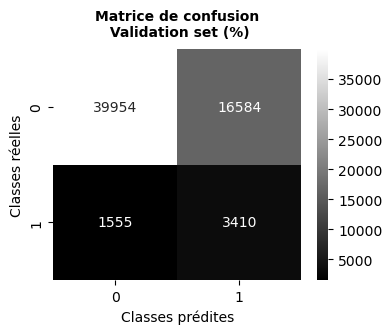

In [120]:
for i, sampling_strat in enumerate([0.2, 0.4, 0.6, 0.8]):
    # Définition de la stratégie d'undersampling
    undersample = RandomUnderSampler(sampling_strategy = sampling_strat)
    # Fitting et sampling sur le jeu d'entrainement
    train_under, train_labels_under = undersample.fit_resample(train, 
                                                               train_labels)
    # Création du modèle 
    lgb_under = lgb.LGBMClassifier(objective = 'binary', 
                                   boosting_type = 'goss', 
                                   n_estimators = 10000, 
                                   class_weight = 'balanced')
    # Calcul des différents scores et compilation des scores du modèle dans un dataframe
    scores(f'LightGBM_under_0.{(i+1)*2}_balanced', lgb_under, train_under, val, 
        train_labels_under, val_labels, results, 
        fit_params = {'early_stopping_rounds': 200, 
                      'eval_set': [(train, train_labels), (val, val_labels)], 
                      'eval_metric': 'auc', 
                      'verbose': 100})

<span class="text-info">*Observations :*  
En associant l'undersampling (sampling_strategy = sampling_strat) avec la class_weight = 'balanced' de LightGBM, nous obtenons de meilleurs résultats.

##### Méthode n°3 : SMOTE

In [121]:
# Définition de la stratégie d'oversampling
oversample = SMOTE()

In [122]:
# Fitting et sampling sur le jeu d'entrainement
train_smote, train_labels_smote = oversample.fit_resample(train, 
                                                          train_labels)

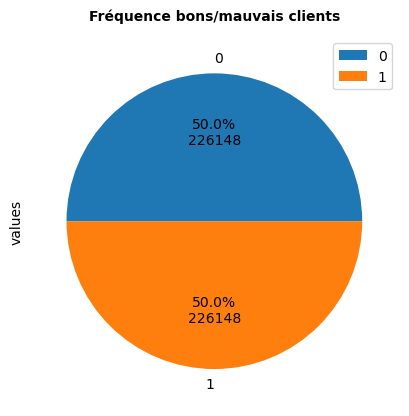

In [123]:
# Visualisation graphique via piechart
tmp = train_labels_smote.value_counts()
df = pd.DataFrame({'labels': tmp.index,
                   'values': tmp.values})
total = df['values'].sum()
df.plot(kind = 'pie', y = 'values', autopct = fmt)
ax = plt.title('Fréquence bons/mauvais clients', fontsize = 10, 
               y = 1.02, fontweight = 'bold')

In [124]:
# Création du modèle 
lgb_smote = lgb.LGBMClassifier(objective = 'binary', 
                               boosting_type = 'goss', 
                               n_estimators = 10000, 
                               class_weight = None)

[100]	valid_0's auc: 0.80659	valid_0's binary_logloss: 0.231439	valid_1's auc: 0.773007	valid_1's binary_logloss: 0.242727
[200]	valid_0's auc: 0.85351	valid_0's binary_logloss: 0.212244	valid_1's auc: 0.773801	valid_1's binary_logloss: 0.242238
[300]	valid_0's auc: 0.888655	valid_0's binary_logloss: 0.196443	valid_1's auc: 0.772616	valid_1's binary_logloss: 0.243144
Results on validation set:
Accuracy score:    0.919
Precision score:   0.506
Recall score:      0.035
F1 score:          0.0655
F2 score:          0.043
ROCAUC score:      0.775


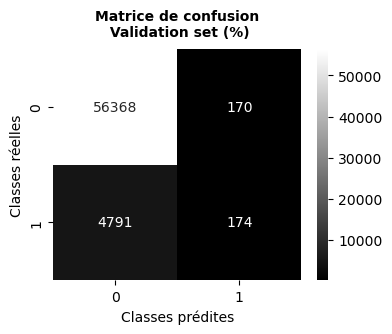

,classifier,TN_val,FP_val,FN_val,TP_val,cost,train_accuracy,val_accuracy,train_precision,val_precision,train_recall,val_recall,train_F1_score,val_F1_score,train_F2_score,val_F2_score,train_roc_auc,val_roc_auc,train_time,predict_time
0,Dummy,52121,4417,4574,391,50157,0.851436,0.853812,0.082550,0.081323,0.083082,0.078751,0.082815,0.080016,0.082975,0.079252,0.500997,0.500313,0.006616,0.001636
1,Logistic regression,56519,19,4962,3,49639,0.919060,0.919012,0.197674,0.136364,0.000856,0.000604,0.001705,0.001203,0.001069,0.000754,0.597383,0.591832,20.659498,0.025115
2,LightGBM,56344,194,4758,207,47774,0.923059,0.919484,0.779042,0.516209,0.065509,0.041692,0.120855,0.077152,0.080200,0.051083,0.836274,0.773890,34.421287,0.109799
3,LightGBM_balanced,42001,14537,1629,3336,30827,0.754077,0.737151,0.216133,0.186650,0.779003,0.671903,0.338382,0.292145,0.512214,0.442053,0.846455,0.778751,34.627094,0.137321
4,LightGBM_under_maj,39113,17425,1481,3484,32235,0.735524,0.692600,0.732769,0.166627,0.741440,0.701712,0.737079,0.269305,0.739690,0.427285,0.814627,0.762605,12.696022,0.074160
5,LightGBM_under_0.2,55175,1363,4204,761,43403,0.849438,0.909484,0.680731,0.358286,0.181974,0.153273,0.287179,0.214699,0.213218,0.173080,0.814331,0.760502,20.949220,0.086882
6,LightGBM_under_0.4,51608,4930,3216,1749,37090,0.777687,0.867551,0.694090,0.261866,0.396777,0.352266,0.504918,0.300412,0.433954,0.329515,0.808888,0.761764,15.851674,0.076393
7,LightGBM_under_0.6,47309,9229,2381,2584,33039,0.747772,0.811229,0.704311,0.218742,0.564300,0.520443,0.626579,0.308022,0.587665,0.407918,0.811142,0.764081,14.112130,0.075627
8,LightGBM_under_0.8,43324,13214,1877,3088,31984,0.754011,0.754630,0.740169,0.189425,0.688066,0.621954,0.713167,0.290403,0.697892,0.426968,0.832693,0.763799,16.911446,0.106720
9,LightGBM_under_0.2_balanced,41545,14993,1646,3319,31453,0.744419,0.729460,0.366424,0.181247,0.731722,0.668479,0.488315,0.285174,0.610081,0.434743,0.817789,0.770868,22.568989,0.098162


In [125]:
# Calcul des différents scores et compilation des scores du modèle dans un dataframe
scores('LightGBM_smote', lgb_smote, train_smote, val, 
        train_labels_smote, val_labels, results, 
        fit_params = {'early_stopping_rounds': 200, 
                      'eval_set': [(train, train_labels), (val, val_labels)], 
                      'eval_metric': 'auc', 
                      'verbose': 100})

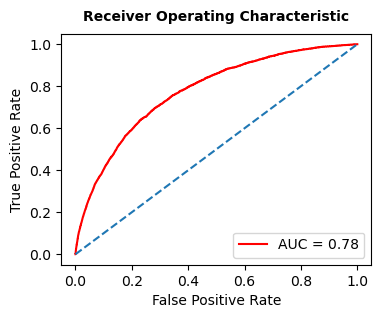

In [126]:
# Représentation graphique de la ROC_curve
ROC_curve('LightGBM_smote', lgb_smote, val, val_labels)

<span class="text-info">*Observations :*  
La méthode SMOTE triple le nombre de FN par rapport à l'utilisation simple de class_weight = 'balanced' dans LightGBM. Nous allons donc finalement utiliser la méthode intégrée à LightGBM pour le rééquilibrage.

#### Création d'un fonction custom FN/FP avec seuil de probabilité

In [127]:
# Définition de la fonction custom afin de minimiser les FN et FP 
# (avec un poids plus important de minimisation des FN (FN 10 fois plus coûteux))
def CustomScores(y_true, p_pred): 
    fn_value = 10
    fp_value = 1
    y_pred = (p_pred >= threshold).astype(int)
    # Récupération des TN, FP, FN, TP
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    # Définition des métriques à minimiser/maximiser
    score = fn*fn_value + fp*fp_value
    F1_score = f1_score(y_true, y_pred)
    return [('CustomScore', score, False), ('F1_score', F1_score, True)]

[100]	training's binary_logloss: 0.516535	training's CustomScore: 213621	training's F1_score: 0.156766	valid_1's binary_logloss: 0.538491	valid_1's CustomScore: 53765	valid_1's F1_score: 0.155778
[200]	training's binary_logloss: 0.473614	training's CustomScore: 203167	training's F1_score: 0.163529	valid_1's binary_logloss: 0.511973	valid_1's CustomScore: 51560	valid_1's F1_score: 0.161265
[300]	training's binary_logloss: 0.43922	training's CustomScore: 195214	training's F1_score: 0.169068	valid_1's binary_logloss: 0.490362	valid_1's CustomScore: 49855	valid_1's F1_score: 0.165866
[400]	training's binary_logloss: 0.409579	training's CustomScore: 188993	training's F1_score: 0.173667	valid_1's binary_logloss: 0.471398	valid_1's CustomScore: 48728	valid_1's F1_score: 0.169
[500]	training's binary_logloss: 0.38264	training's CustomScore: 181862	training's F1_score: 0.179256	valid_1's binary_logloss: 0.454742	valid_1's CustomScore: 47313	valid_1's F1_score: 0.173237
[600]	training's binary_l

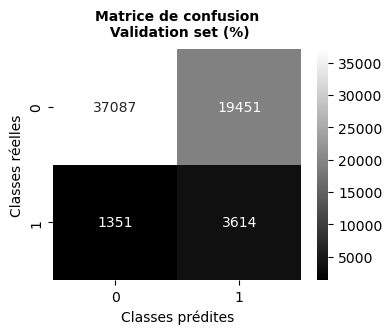

[100]	training's binary_logloss: 0.516535	training's CustomScore: 170151	training's F1_score: 0.189393	valid_1's binary_logloss: 0.538491	valid_1's CustomScore: 44022	valid_1's F1_score: 0.184151
[200]	training's binary_logloss: 0.473614	training's CustomScore: 155172	training's F1_score: 0.20405	valid_1's binary_logloss: 0.511973	valid_1's CustomScore: 41657	valid_1's F1_score: 0.193204
[300]	training's binary_logloss: 0.43922	training's CustomScore: 144606	training's F1_score: 0.215682	valid_1's binary_logloss: 0.490362	valid_1's CustomScore: 40160	valid_1's F1_score: 0.199687
[400]	training's binary_logloss: 0.409579	training's CustomScore: 136381	training's F1_score: 0.225698	valid_1's binary_logloss: 0.471398	valid_1's CustomScore: 38929	valid_1's F1_score: 0.205498
[500]	training's binary_logloss: 0.38264	training's CustomScore: 128197	training's F1_score: 0.236682	valid_1's binary_logloss: 0.454742	valid_1's CustomScore: 37684	valid_1's F1_score: 0.211886
[600]	training's binary

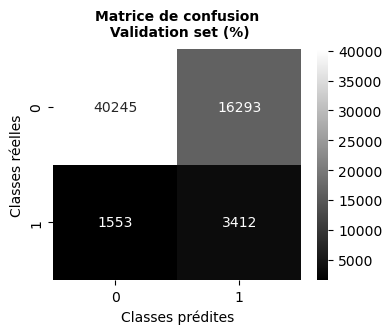

[100]	training's binary_logloss: 0.516535	training's CustomScore: 135229	training's F1_score: 0.230838	valid_1's binary_logloss: 0.538491	valid_1's CustomScore: 36618	valid_1's F1_score: 0.218124
[200]	training's binary_logloss: 0.473614	training's CustomScore: 119559	training's F1_score: 0.253455	valid_1's binary_logloss: 0.511973	valid_1's CustomScore: 35025	valid_1's F1_score: 0.228617
[300]	training's binary_logloss: 0.43922	training's CustomScore: 108411	training's F1_score: 0.271824	valid_1's binary_logloss: 0.490362	valid_1's CustomScore: 33692	valid_1's F1_score: 0.238044
[400]	training's binary_logloss: 0.409579	training's CustomScore: 99547	training's F1_score: 0.288398	valid_1's binary_logloss: 0.471398	valid_1's CustomScore: 33141	valid_1's F1_score: 0.24394
[500]	training's binary_logloss: 0.38264	training's CustomScore: 91670	training's F1_score: 0.304956	valid_1's binary_logloss: 0.454742	valid_1's CustomScore: 32812	valid_1's F1_score: 0.248668
[600]	training's binary_l

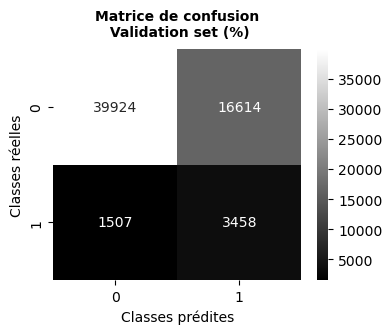

[100]	training's binary_logloss: 0.516535	training's CustomScore: 114273	training's F1_score: 0.275831	valid_1's binary_logloss: 0.538491	valid_1's CustomScore: 32295	valid_1's F1_score: 0.254142
[200]	training's binary_logloss: 0.473614	training's CustomScore: 99571	training's F1_score: 0.305271	valid_1's binary_logloss: 0.511973	valid_1's CustomScore: 31735	valid_1's F1_score: 0.262845
[300]	training's binary_logloss: 0.43922	training's CustomScore: 87287	training's F1_score: 0.332707	valid_1's binary_logloss: 0.490362	valid_1's CustomScore: 31298	valid_1's F1_score: 0.270434
[400]	training's binary_logloss: 0.409579	training's CustomScore: 77458	training's F1_score: 0.358139	valid_1's binary_logloss: 0.471398	valid_1's CustomScore: 31224	valid_1's F1_score: 0.275886
[500]	training's binary_logloss: 0.38264	training's CustomScore: 69229	training's F1_score: 0.382329	valid_1's binary_logloss: 0.454742	valid_1's CustomScore: 31342	valid_1's F1_score: 0.279621
Results on validation set:

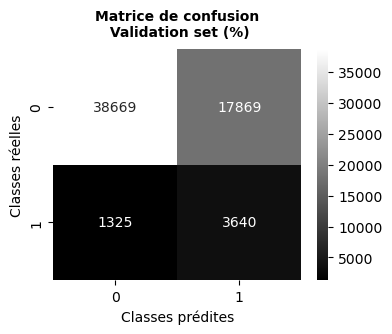

[100]	training's binary_logloss: 0.516535	training's CustomScore: 106938	training's F1_score: 0.320036	valid_1's binary_logloss: 0.538491	valid_1's CustomScore: 30934	valid_1's F1_score: 0.288033
[200]	training's binary_logloss: 0.473614	training's CustomScore: 93207	training's F1_score: 0.356914	valid_1's binary_logloss: 0.511973	valid_1's CustomScore: 30923	valid_1's F1_score: 0.295162
[300]	training's binary_logloss: 0.43922	training's CustomScore: 81018	training's F1_score: 0.392405	valid_1's binary_logloss: 0.490362	valid_1's CustomScore: 31297	valid_1's F1_score: 0.298231
Results on validation set:
Accuracy score:    0.739
Precision score:   0.188
Recall score:      0.672
F1 score:          0.294
F2 score:          0.44
ROCAUC score:      0.779


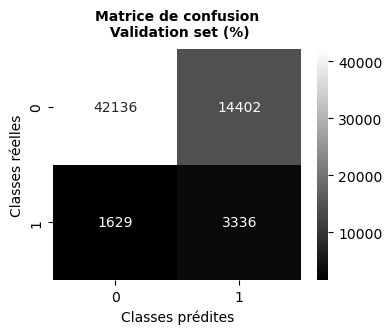

[100]	training's binary_logloss: 0.516535	training's CustomScore: 110994	training's F1_score: 0.360516	valid_1's binary_logloss: 0.538491	valid_1's CustomScore: 32117	valid_1's F1_score: 0.315457
[200]	training's binary_logloss: 0.473614	training's CustomScore: 99207	training's F1_score: 0.401697	valid_1's binary_logloss: 0.511973	valid_1's CustomScore: 32129	valid_1's F1_score: 0.322279
[300]	training's binary_logloss: 0.43922	training's CustomScore: 88469	training's F1_score: 0.442419	valid_1's binary_logloss: 0.490362	valid_1's CustomScore: 32623	valid_1's F1_score: 0.323071
Results on validation set:
Accuracy score:    0.816
Precision score:   0.229
Recall score:      0.539
F1 score:          0.321
F2 score:          0.42
ROCAUC score:      0.779


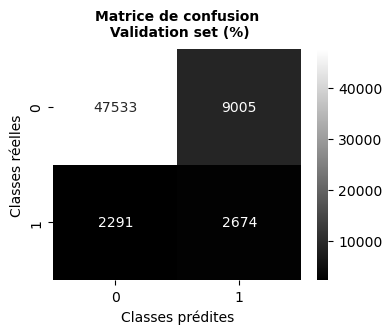

[100]	training's binary_logloss: 0.516535	training's CustomScore: 128951	training's F1_score: 0.373707	valid_1's binary_logloss: 0.538491	valid_1's CustomScore: 35287	valid_1's F1_score: 0.327044
[200]	training's binary_logloss: 0.473614	training's CustomScore: 118456	training's F1_score: 0.418971	valid_1's binary_logloss: 0.511973	valid_1's CustomScore: 35608	valid_1's F1_score: 0.326106
[300]	training's binary_logloss: 0.43922	training's CustomScore: 108988	training's F1_score: 0.463713	valid_1's binary_logloss: 0.490362	valid_1's CustomScore: 36324	valid_1's F1_score: 0.319616
Results on validation set:
Accuracy score:    0.871
Precision score:   0.283
Recall score:      0.388
F1 score:          0.327
F2 score:          0.36
ROCAUC score:      0.777


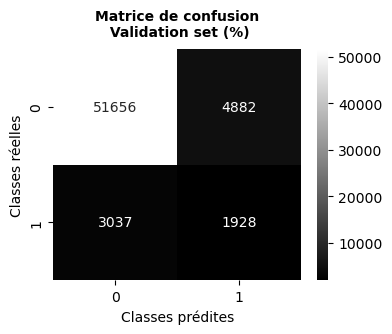

[100]	training's binary_logloss: 0.516535	training's CustomScore: 159063	training's F1_score: 0.300295	valid_1's binary_logloss: 0.538491	valid_1's CustomScore: 41714	valid_1's F1_score: 0.253205
[200]	training's binary_logloss: 0.473614	training's CustomScore: 150837	training's F1_score: 0.346985	valid_1's binary_logloss: 0.511973	valid_1's CustomScore: 41188	valid_1's F1_score: 0.264737
[300]	training's binary_logloss: 0.43922	training's CustomScore: 144552	training's F1_score: 0.384505	valid_1's binary_logloss: 0.490362	valid_1's CustomScore: 41578	valid_1's F1_score: 0.256295
Results on validation set:
Accuracy score:    0.908
Precision score:   0.375
Recall score:      0.206
F1 score:          0.266
F2 score:          0.23
ROCAUC score:      0.778


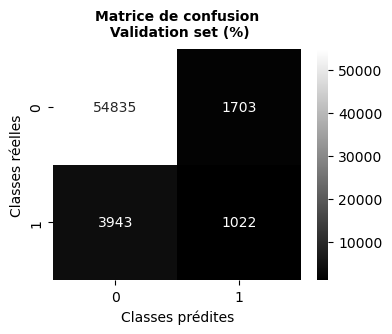

[100]	training's binary_logloss: 0.516535	training's CustomScore: 192885	training's F1_score: 0.0577795	valid_1's binary_logloss: 0.538491	valid_1's CustomScore: 48626	valid_1's F1_score: 0.0433018
[200]	training's binary_logloss: 0.473614	training's CustomScore: 188704	training's F1_score: 0.0968725	valid_1's binary_logloss: 0.511973	valid_1's CustomScore: 47930	valid_1's F1_score: 0.0707698
[300]	training's binary_logloss: 0.43922	training's CustomScore: 185875	training's F1_score: 0.12179	valid_1's binary_logloss: 0.490362	valid_1's CustomScore: 47803	valid_1's F1_score: 0.076091
[400]	training's binary_logloss: 0.409579	training's CustomScore: 183667	training's F1_score: 0.140707	valid_1's binary_logloss: 0.471398	valid_1's CustomScore: 47881	valid_1's F1_score: 0.0732436
[500]	training's binary_logloss: 0.38264	training's CustomScore: 182117	training's F1_score: 0.153755	valid_1's binary_logloss: 0.454742	valid_1's CustomScore: 47814	valid_1's F1_score: 0.0752809
[600]	training's 

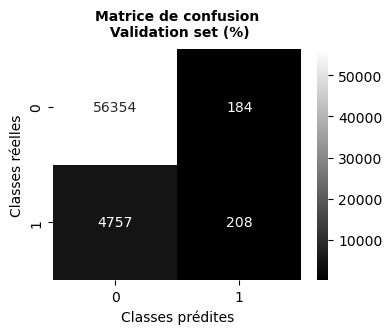

In [128]:
for i, threshold in enumerate([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]):
    # Création du modèle 
    lgb_balanced = lgb.LGBMClassifier(objective = 'binary', 
                                      boosting_type = 'goss', 
                                      n_estimators = 10000, 
                                          class_weight = 'balanced')
    # Calcul des différents scores et compilation des scores du modèle dans un dataframe
    df_results = scores(f'LightGBM_balanced_custom_threshold_0.{(i+1)}', lgb_balanced, train, val, 
                        train_labels, val_labels, results, 
                        fit_params = {'early_stopping_rounds': 200, 
                                      'eval_set': [(train, train_labels), (val, val_labels)], 
                                      'eval_metric': CustomScores, 
                                      'verbose': 100},
                        threshold = threshold)

In [129]:
# Affichage des resultats et tri en fonction du coût
df_results.sort_values(by='cost')

,classifier,TN_val,FP_val,FN_val,TP_val,cost,train_accuracy,val_accuracy,train_precision,val_precision,train_recall,val_recall,train_F1_score,val_F1_score,train_F2_score,val_F2_score,train_roc_auc,val_roc_auc,train_time,predict_time
18,LightGBM_balanced_custom_threshold_0.5,42136,14402,1629,3336,30692,0.756244,0.739346,0.218262,0.188071,0.782226,0.671903,0.341294,0.293882,0.515715,0.443641,0.849817,0.778624,211.608164,0.148474
3,LightGBM_balanced,42001,14537,1629,3336,30827,0.754077,0.737151,0.216133,0.186650,0.779003,0.671903,0.338382,0.292145,0.512214,0.442053,0.846455,0.778751,34.627094,0.137321
17,LightGBM_balanced_custom_threshold_0.4,38669,17869,1325,3640,31119,0.719375,0.687918,0.215146,0.169231,0.935096,0.733132,0.349809,0.274987,0.560184,0.439943,0.907767,0.777727,332.620240,0.251612
9,LightGBM_under_0.2_balanced,41545,14993,1646,3319,31453,0.744419,0.729460,0.366424,0.181247,0.731722,0.668479,0.488315,0.285174,0.610081,0.434743,0.817789,0.770868,22.568989,0.098162
16,LightGBM_balanced_custom_threshold_0.3,39924,16614,1507,3458,31684,0.766951,0.705364,0.257104,0.172280,0.998590,0.696475,0.408924,0.276231,0.633303,0.432986,0.984066,0.766195,765.163819,0.607139
11,LightGBM_under_0.6_balanced,40242,16296,1540,3425,31696,0.745185,0.709998,0.636958,0.173673,0.745267,0.689829,0.686869,0.277485,0.720755,0.432657,0.825566,0.764986,18.155201,0.108071
10,LightGBM_under_0.4_balanced,40981,15557,1621,3344,31767,0.745907,0.720697,0.540315,0.176922,0.741641,0.673515,0.625170,0.280231,0.690206,0.431361,0.823109,0.766777,20.309456,0.111305
15,LightGBM_balanced_custom_threshold_0.2,40245,16293,1553,3412,31823,0.791588,0.709835,0.279203,0.173154,1.000000,0.687210,0.436527,0.276611,0.659490,0.431189,0.998448,0.759304,1308.237235,1.082883
19,LightGBM_balanced_custom_threshold_0.6,47533,9005,2291,2674,31915,0.831615,0.816334,0.272003,0.228958,0.647684,0.538570,0.383112,0.321317,0.507496,0.423920,0.849817,0.778624,210.512730,0.149219
8,LightGBM_under_0.8,43324,13214,1877,3088,31984,0.754011,0.754630,0.740169,0.189425,0.688066,0.621954,0.713167,0.290403,0.697892,0.426968,0.832693,0.763799,16.911446,0.106720


<span class="text-info">*Observations :*  
La fonction custom permet la détermination du seuil de prédition optimal = le seuil est optimal pour 0,5, c'est à dire le seuil standard utilisé par la méthode predict_proba.  
La fonction permet également d'optimiser le coût : un compromis entre FP et FN semble être trouvé.

#### Suppression des colinéarités

In [130]:
# Chargement du dataset pour modélisation
train_corrs_removed = pd.read_csv('train_corrs_removed.csv')

# Suppression de la target
train_corrs_rem_target = train_corrs_removed['TARGET']
train_corrs_rem = train_corrs_removed.drop(columns = ['SK_ID_CURR', 'TARGET'])

In [131]:
# Imputation des valeurs manquantes par la médiane
imputer = SimpleImputer(strategy = 'median')
imputer.fit(train_corrs_rem)
train_corrs_rem = imputer.transform(train_corrs_rem)

In [132]:
# Splitting du jeu train en train+val
train_corr, val_corr, train_corr_labels, val_corr_labels = train_test_split(train_corrs_rem, 
                                                                            train_corrs_rem_target, 
                                                                            test_size = 0.2, 
                                                                            stratify = train_corrs_rem_target,
                                                                            random_state = 56)

In [133]:
print('Training shape: ', train_corr.shape)
print('Validation shape: ', val_corr.shape)

Training shape:  (246008, 623)
Validation shape:  (61503, 623)


[100]	training's binary_logloss: 0.522351	training's CustomScore: 109012	training's F1_score: 0.314826	valid_1's binary_logloss: 0.541982	valid_1's CustomScore: 31247	valid_1's F1_score: 0.284727
[200]	training's binary_logloss: 0.481888	training's CustomScore: 95823	training's F1_score: 0.349404	valid_1's binary_logloss: 0.516988	valid_1's CustomScore: 31059	valid_1's F1_score: 0.292533
[300]	training's binary_logloss: 0.448519	training's CustomScore: 84224	training's F1_score: 0.382682	valid_1's binary_logloss: 0.496035	valid_1's CustomScore: 31424	valid_1's F1_score: 0.295597
[400]	training's binary_logloss: 0.41986	training's CustomScore: 73775	training's F1_score: 0.414333	valid_1's binary_logloss: 0.478019	valid_1's CustomScore: 31444	valid_1's F1_score: 0.300746
Results on validation set:
Accuracy score:    0.744
Precision score:   0.189
Recall score:      0.659
F1 score:          0.293
F2 score:          0.44
ROCAUC score:      0.777


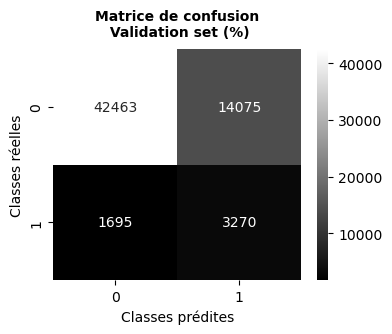

,classifier,TN_val,FP_val,FN_val,TP_val,cost,train_accuracy,val_accuracy,train_precision,val_precision,train_recall,val_recall,train_F1_score,val_F1_score,train_F2_score,val_F2_score,train_roc_auc,val_roc_auc,train_time,predict_time
0,Dummy,52121,4417,4574,391,50157,0.851436,0.853812,0.082550,0.081323,0.083082,0.078751,0.082815,0.080016,0.082975,0.079252,0.500997,0.500313,0.006616,0.001636
1,Logistic regression,56519,19,4962,3,49639,0.919060,0.919012,0.197674,0.136364,0.000856,0.000604,0.001705,0.001203,0.001069,0.000754,0.597383,0.591832,20.659498,0.025115
2,LightGBM,56344,194,4758,207,47774,0.923059,0.919484,0.779042,0.516209,0.065509,0.041692,0.120855,0.077152,0.080200,0.051083,0.836274,0.773890,34.421287,0.109799
3,LightGBM_balanced,42001,14537,1629,3336,30827,0.754077,0.737151,0.216133,0.186650,0.779003,0.671903,0.338382,0.292145,0.512214,0.442053,0.846455,0.778751,34.627094,0.137321
4,LightGBM_under_maj,39113,17425,1481,3484,32235,0.735524,0.692600,0.732769,0.166627,0.741440,0.701712,0.737079,0.269305,0.739690,0.427285,0.814627,0.762605,12.696022,0.074160
5,LightGBM_under_0.2,55175,1363,4204,761,43403,0.849438,0.909484,0.680731,0.358286,0.181974,0.153273,0.287179,0.214699,0.213218,0.173080,0.814331,0.760502,20.949220,0.086882
6,LightGBM_under_0.4,51608,4930,3216,1749,37090,0.777687,0.867551,0.694090,0.261866,0.396777,0.352266,0.504918,0.300412,0.433954,0.329515,0.808888,0.761764,15.851674,0.076393
7,LightGBM_under_0.6,47309,9229,2381,2584,33039,0.747772,0.811229,0.704311,0.218742,0.564300,0.520443,0.626579,0.308022,0.587665,0.407918,0.811142,0.764081,14.112130,0.075627
8,LightGBM_under_0.8,43324,13214,1877,3088,31984,0.754011,0.754630,0.740169,0.189425,0.688066,0.621954,0.713167,0.290403,0.697892,0.426968,0.832693,0.763799,16.911446,0.106720
9,LightGBM_under_0.2_balanced,41545,14993,1646,3319,31453,0.744419,0.729460,0.366424,0.181247,0.731722,0.668479,0.488315,0.285174,0.610081,0.434743,0.817789,0.770868,22.568989,0.098162


In [134]:
# Création du modèle 
lgb_balanced = lgb.LGBMClassifier(objective = 'binary', 
                                  boosting_type = 'goss', 
                                  n_estimators = 10000, 
                                  class_weight = 'balanced')

# Calcul des différents scores et compilation des scores du modèle dans un dataframe
threshold = 0.5
scores('LightGBM_corrs_removed', lgb_balanced, train_corr, val_corr, 
        train_corr_labels, val_corr_labels, results, 
        fit_params = {'early_stopping_rounds': 200, 
                      'eval_set': [(train_corr, train_corr_labels), 
                                   (val_corr, val_corr_labels)], 
                      'eval_metric': CustomScores, 
                      'verbose': 100},
      threshold = threshold)

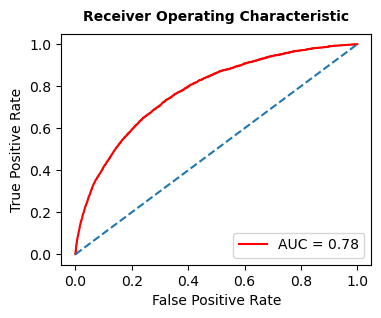

In [135]:
# Représentation graphique de la ROC_curve
ROC_curve('LightGBM_corrs_removed', lgb_balanced, val_corr, val_corr_labels)

<span class="text-info">*Observations :*  
L'entrainement de ce modèle sur les données sans colinéarité donne des performances similaires en termes de nombres de FN, FP, autres métriques et de temps d'apprentissage/prédiction.

[100]	training's binary_logloss: 0.522351	training's CustomScore: 214521	training's F1_score: 0.156212	valid_1's binary_logloss: 0.541982	valid_1's CustomScore: 53933	valid_1's F1_score: 0.15538
[200]	training's binary_logloss: 0.481888	training's CustomScore: 204817	training's F1_score: 0.162425	valid_1's binary_logloss: 0.516988	valid_1's CustomScore: 51783	valid_1's F1_score: 0.160729
[300]	training's binary_logloss: 0.448519	training's CustomScore: 197567	training's F1_score: 0.16739	valid_1's binary_logloss: 0.496035	valid_1's CustomScore: 50389	valid_1's F1_score: 0.164377
[400]	training's binary_logloss: 0.41986	training's CustomScore: 190943	training's F1_score: 0.172199	valid_1's binary_logloss: 0.478019	valid_1's CustomScore: 49198	valid_1's F1_score: 0.167637
[500]	training's binary_logloss: 0.394237	training's CustomScore: 184553	training's F1_score: 0.177106	valid_1's binary_logloss: 0.461742	valid_1's CustomScore: 47903	valid_1's F1_score: 0.171425
[600]	training's binary

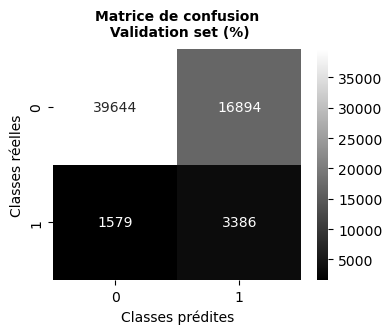

[100]	training's binary_logloss: 0.522351	training's CustomScore: 171596	training's F1_score: 0.188091	valid_1's binary_logloss: 0.541982	valid_1's CustomScore: 44147	valid_1's F1_score: 0.183707
[200]	training's binary_logloss: 0.481888	training's CustomScore: 157420	training's F1_score: 0.201726	valid_1's binary_logloss: 0.516988	valid_1's CustomScore: 41968	valid_1's F1_score: 0.191949
[300]	training's binary_logloss: 0.448519	training's CustomScore: 147439	training's F1_score: 0.212447	valid_1's binary_logloss: 0.496035	valid_1's CustomScore: 40437	valid_1's F1_score: 0.198402
[400]	training's binary_logloss: 0.41986	training's CustomScore: 139211	training's F1_score: 0.222154	valid_1's binary_logloss: 0.478019	valid_1's CustomScore: 39362	valid_1's F1_score: 0.203409
[500]	training's binary_logloss: 0.394237	training's CustomScore: 131811	training's F1_score: 0.231702	valid_1's binary_logloss: 0.461742	valid_1's CustomScore: 38358	valid_1's F1_score: 0.208545
[600]	training's bina

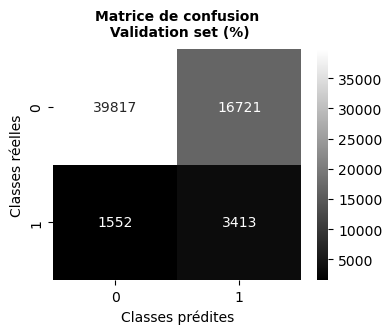

[100]	training's binary_logloss: 0.522351	training's CustomScore: 137029	training's F1_score: 0.228506	valid_1's binary_logloss: 0.541982	valid_1's CustomScore: 36857	valid_1's F1_score: 0.216851
[200]	training's binary_logloss: 0.481888	training's CustomScore: 122800	training's F1_score: 0.248638	valid_1's binary_logloss: 0.516988	valid_1's CustomScore: 35459	valid_1's F1_score: 0.225927
[300]	training's binary_logloss: 0.448519	training's CustomScore: 111520	training's F1_score: 0.266529	valid_1's binary_logloss: 0.496035	valid_1's CustomScore: 34370	valid_1's F1_score: 0.233794
[400]	training's binary_logloss: 0.41986	training's CustomScore: 102564	training's F1_score: 0.282379	valid_1's binary_logloss: 0.478019	valid_1's CustomScore: 33778	valid_1's F1_score: 0.239206
[500]	training's binary_logloss: 0.394237	training's CustomScore: 95181	training's F1_score: 0.297253	valid_1's binary_logloss: 0.461742	valid_1's CustomScore: 33387	valid_1's F1_score: 0.24382
[600]	training's binary

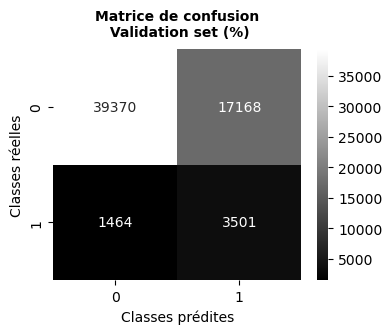

[100]	training's binary_logloss: 0.522351	training's CustomScore: 116790	training's F1_score: 0.271513	valid_1's binary_logloss: 0.541982	valid_1's CustomScore: 32706	valid_1's F1_score: 0.251341
[200]	training's binary_logloss: 0.481888	training's CustomScore: 102384	training's F1_score: 0.299588	valid_1's binary_logloss: 0.516988	valid_1's CustomScore: 32042	valid_1's F1_score: 0.259775
[300]	training's binary_logloss: 0.448519	training's CustomScore: 90410	training's F1_score: 0.325335	valid_1's binary_logloss: 0.496035	valid_1's CustomScore: 31664	valid_1's F1_score: 0.266777
[400]	training's binary_logloss: 0.41986	training's CustomScore: 80971	training's F1_score: 0.348368	valid_1's binary_logloss: 0.478019	valid_1's CustomScore: 31505	valid_1's F1_score: 0.271623
[500]	training's binary_logloss: 0.394237	training's CustomScore: 72582	training's F1_score: 0.371241	valid_1's binary_logloss: 0.461742	valid_1's CustomScore: 31506	valid_1's F1_score: 0.275757
[600]	training's binary_

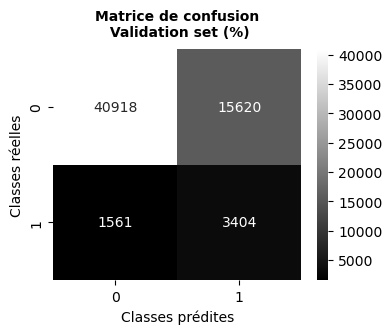

[100]	training's binary_logloss: 0.522351	training's CustomScore: 109012	training's F1_score: 0.314826	valid_1's binary_logloss: 0.541982	valid_1's CustomScore: 31247	valid_1's F1_score: 0.284727
[200]	training's binary_logloss: 0.481888	training's CustomScore: 95823	training's F1_score: 0.349404	valid_1's binary_logloss: 0.516988	valid_1's CustomScore: 31059	valid_1's F1_score: 0.292533
[300]	training's binary_logloss: 0.448519	training's CustomScore: 84224	training's F1_score: 0.382682	valid_1's binary_logloss: 0.496035	valid_1's CustomScore: 31424	valid_1's F1_score: 0.295597
[400]	training's binary_logloss: 0.41986	training's CustomScore: 73775	training's F1_score: 0.414333	valid_1's binary_logloss: 0.478019	valid_1's CustomScore: 31444	valid_1's F1_score: 0.300746
Results on validation set:
Accuracy score:    0.744
Precision score:   0.189
Recall score:      0.659
F1 score:          0.293
F2 score:          0.44
ROCAUC score:      0.777


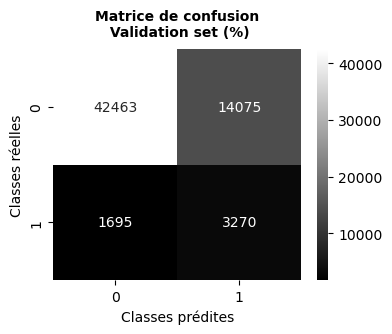

[100]	training's binary_logloss: 0.522351	training's CustomScore: 113034	training's F1_score: 0.353533	valid_1's binary_logloss: 0.541982	valid_1's CustomScore: 32139	valid_1's F1_score: 0.314032
[200]	training's binary_logloss: 0.481888	training's CustomScore: 101333	training's F1_score: 0.393368	valid_1's binary_logloss: 0.516988	valid_1's CustomScore: 32343	valid_1's F1_score: 0.318
Results on validation set:
Accuracy score:    0.807
Precision score:   0.22
Recall score:      0.548
F1 score:          0.314
F2 score:          0.42
ROCAUC score:      0.774


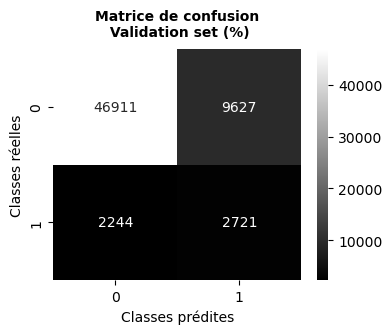

[100]	training's binary_logloss: 0.522351	training's CustomScore: 129581	training's F1_score: 0.369864	valid_1's binary_logloss: 0.541982	valid_1's CustomScore: 35725	valid_1's F1_score: 0.318889
[200]	training's binary_logloss: 0.481888	training's CustomScore: 120593	training's F1_score: 0.409358	valid_1's binary_logloss: 0.516988	valid_1's CustomScore: 35599	valid_1's F1_score: 0.325121
[300]	training's binary_logloss: 0.448519	training's CustomScore: 112119	training's F1_score: 0.449318	valid_1's binary_logloss: 0.496035	valid_1's CustomScore: 36238	valid_1's F1_score: 0.32018
Results on validation set:
Accuracy score:    0.873
Precision score:   0.285
Recall score:      0.381
F1 score:          0.326
F2 score:          0.36
ROCAUC score:      0.777


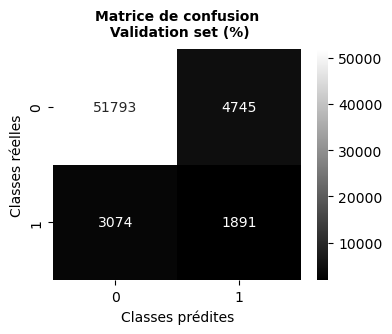

[100]	training's binary_logloss: 0.522351	training's CustomScore: 160082	training's F1_score: 0.294133	valid_1's binary_logloss: 0.541982	valid_1's CustomScore: 41688	valid_1's F1_score: 0.254078
[200]	training's binary_logloss: 0.481888	training's CustomScore: 151990	training's F1_score: 0.340341	valid_1's binary_logloss: 0.516988	valid_1's CustomScore: 41278	valid_1's F1_score: 0.262697
[300]	training's binary_logloss: 0.448519	training's CustomScore: 146197	training's F1_score: 0.375131	valid_1's binary_logloss: 0.496035	valid_1's CustomScore: 41463	valid_1's F1_score: 0.259215
Results on validation set:
Accuracy score:    0.909
Precision score:   0.377
Recall score:      0.204
F1 score:          0.265
F2 score:          0.22
ROCAUC score:      0.777


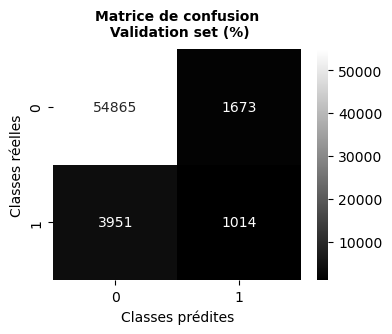

[100]	training's binary_logloss: 0.522351	training's CustomScore: 193275	training's F1_score: 0.0539154	valid_1's binary_logloss: 0.541982	valid_1's CustomScore: 48624	valid_1's F1_score: 0.0430233
[200]	training's binary_logloss: 0.481888	training's CustomScore: 189458	training's F1_score: 0.0899967	valid_1's binary_logloss: 0.516988	valid_1's CustomScore: 47856	valid_1's F1_score: 0.0731385
[300]	training's binary_logloss: 0.448519	training's CustomScore: 186864	training's F1_score: 0.113081	valid_1's binary_logloss: 0.496035	valid_1's CustomScore: 47771	valid_1's F1_score: 0.0767647
[400]	training's binary_logloss: 0.41986	training's CustomScore: 185208	training's F1_score: 0.127384	valid_1's binary_logloss: 0.478019	valid_1's CustomScore: 47755	valid_1's F1_score: 0.0774266
[500]	training's binary_logloss: 0.394237	training's CustomScore: 183559	training's F1_score: 0.14153	valid_1's binary_logloss: 0.461742	valid_1's CustomScore: 47837	valid_1's F1_score: 0.0747384
Results on vali

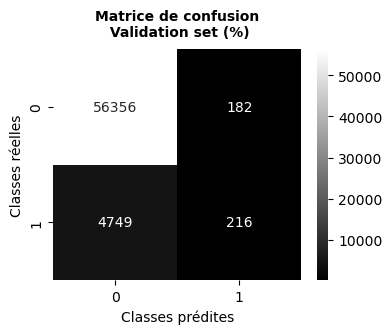

In [136]:
# Nouvelle détermination du seuil optimal suite à la suppression de presque moitié des variables
for i, threshold in enumerate([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]):
    # Création du modèle 
    lgb_balanced = lgb.LGBMClassifier(objective = 'binary', 
                                      boosting_type = 'goss', 
                                      n_estimators = 10000, 
                                      class_weight = 'balanced')
    # Calcul des différents scores et compilation des scores du modèle dans un dataframe
    df_results = scores(f'LightGBM_balanced_custom_cors_rem_threshold_0.{(i+1)}', lgb_balanced, train_corr, val_corr, 
        train_corr_labels, val_corr_labels, results, 
        fit_params = {'early_stopping_rounds': 200, 
                      'eval_set': [(train_corr, train_corr_labels), 
                                   (val_corr, val_corr_labels)], 
                                      'eval_metric': CustomScores, 
                                      'verbose': 100},
                        threshold = threshold)

In [137]:
# Affichage des résulats
df_results

,classifier,TN_val,FP_val,FN_val,TP_val,cost,train_accuracy,val_accuracy,train_precision,val_precision,train_recall,val_recall,train_F1_score,val_F1_score,train_F2_score,val_F2_score,train_roc_auc,val_roc_auc,train_time,predict_time
0,Dummy,52121,4417,4574,391,50157,0.851436,0.853812,0.082550,0.081323,0.083082,0.078751,0.082815,0.080016,0.082975,0.079252,0.500997,0.500313,0.006616,0.001636
1,Logistic regression,56519,19,4962,3,49639,0.919060,0.919012,0.197674,0.136364,0.000856,0.000604,0.001705,0.001203,0.001069,0.000754,0.597383,0.591832,20.659498,0.025115
2,LightGBM,56344,194,4758,207,47774,0.923059,0.919484,0.779042,0.516209,0.065509,0.041692,0.120855,0.077152,0.080200,0.051083,0.836274,0.773890,34.421287,0.109799
3,LightGBM_balanced,42001,14537,1629,3336,30827,0.754077,0.737151,0.216133,0.186650,0.779003,0.671903,0.338382,0.292145,0.512214,0.442053,0.846455,0.778751,34.627094,0.137321
4,LightGBM_under_maj,39113,17425,1481,3484,32235,0.735524,0.692600,0.732769,0.166627,0.741440,0.701712,0.737079,0.269305,0.739690,0.427285,0.814627,0.762605,12.696022,0.074160
5,LightGBM_under_0.2,55175,1363,4204,761,43403,0.849438,0.909484,0.680731,0.358286,0.181974,0.153273,0.287179,0.214699,0.213218,0.173080,0.814331,0.760502,20.949220,0.086882
6,LightGBM_under_0.4,51608,4930,3216,1749,37090,0.777687,0.867551,0.694090,0.261866,0.396777,0.352266,0.504918,0.300412,0.433954,0.329515,0.808888,0.761764,15.851674,0.076393
7,LightGBM_under_0.6,47309,9229,2381,2584,33039,0.747772,0.811229,0.704311,0.218742,0.564300,0.520443,0.626579,0.308022,0.587665,0.407918,0.811142,0.764081,14.112130,0.075627
8,LightGBM_under_0.8,43324,13214,1877,3088,31984,0.754011,0.754630,0.740169,0.189425,0.688066,0.621954,0.713167,0.290403,0.697892,0.426968,0.832693,0.763799,16.911446,0.106720
9,LightGBM_under_0.2_balanced,41545,14993,1646,3319,31453,0.744419,0.729460,0.366424,0.181247,0.731722,0.668479,0.488315,0.285174,0.610081,0.434743,0.817789,0.770868,22.568989,0.098162


<span class="text-info">*Observations :*  
Le seuil de prédiction optimal est encore une fois 0,5.

#### Ajout du feature engineering
##### Features polynomiales

In [138]:
# Chargement du dataset pour modélisation
train_corrs_removed_poly = pd.read_csv('train_corrs_removed_poly.csv')

# Suppression de la target
app_train_poly_target = train_corrs_removed_poly['TARGET']
app_train_poly = train_corrs_removed_poly.drop(columns = ['SK_ID_CURR', 'TARGET'])

In [139]:
# Imputation des valeurs manquantes par la médiane
imputer = SimpleImputer(strategy = 'median')
imputer.fit(app_train_poly)
app_train_poly = imputer.transform(app_train_poly)

In [140]:
# Splitting du jeu train en train+val
train_poly, val_poly, train_poly_labels, val_poly_labels = train_test_split(app_train_poly, 
                                                                            app_train_poly_target, 
                                                                            test_size = 0.2, 
                                                                            stratify = app_train_poly_target,
                                                                            random_state = 56)

In [141]:
print('Training shape: ', train_poly.shape)
print('Validation shape: ', val_poly.shape)

Training shape:  (246008, 669)
Validation shape:  (61503, 669)


[100]	training's binary_logloss: 0.519102	training's CustomScore: 193658	training's F1_score: 0.0503925	valid_1's binary_logloss: 0.539753	valid_1's CustomScore: 48590	valid_1's F1_score: 0.0441946
[200]	training's binary_logloss: 0.478311	training's CustomScore: 189137	training's F1_score: 0.0926921	valid_1's binary_logloss: 0.513916	valid_1's CustomScore: 48216	valid_1's F1_score: 0.0599734
[300]	training's binary_logloss: 0.444557	training's CustomScore: 186693	training's F1_score: 0.114509	valid_1's binary_logloss: 0.493111	valid_1's CustomScore: 47963	valid_1's F1_score: 0.0696405
[400]	training's binary_logloss: 0.414781	training's CustomScore: 184944	training's F1_score: 0.129632	valid_1's binary_logloss: 0.474426	valid_1's CustomScore: 47954	valid_1's F1_score: 0.0702216
[500]	training's binary_logloss: 0.389259	training's CustomScore: 182738	training's F1_score: 0.148484	valid_1's binary_logloss: 0.458434	valid_1's CustomScore: 47887	valid_1's F1_score: 0.0727136
[600]	trainin

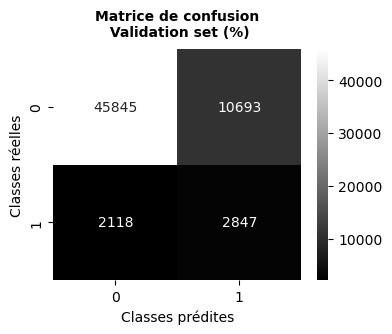

,classifier,TN_val,FP_val,FN_val,TP_val,cost,train_accuracy,val_accuracy,train_precision,val_precision,train_recall,val_recall,train_F1_score,val_F1_score,train_F2_score,val_F2_score,train_roc_auc,val_roc_auc,train_time,predict_time
0,Dummy,52121,4417,4574,391,50157,0.851436,0.853812,0.082550,0.081323,0.083082,0.078751,0.082815,0.080016,0.082975,0.079252,0.500997,0.500313,0.006616,0.001636
1,Logistic regression,56519,19,4962,3,49639,0.919060,0.919012,0.197674,0.136364,0.000856,0.000604,0.001705,0.001203,0.001069,0.000754,0.597383,0.591832,20.659498,0.025115
2,LightGBM,56344,194,4758,207,47774,0.923059,0.919484,0.779042,0.516209,0.065509,0.041692,0.120855,0.077152,0.080200,0.051083,0.836274,0.773890,34.421287,0.109799
3,LightGBM_balanced,42001,14537,1629,3336,30827,0.754077,0.737151,0.216133,0.186650,0.779003,0.671903,0.338382,0.292145,0.512214,0.442053,0.846455,0.778751,34.627094,0.137321
4,LightGBM_under_maj,39113,17425,1481,3484,32235,0.735524,0.692600,0.732769,0.166627,0.741440,0.701712,0.737079,0.269305,0.739690,0.427285,0.814627,0.762605,12.696022,0.074160
5,LightGBM_under_0.2,55175,1363,4204,761,43403,0.849438,0.909484,0.680731,0.358286,0.181974,0.153273,0.287179,0.214699,0.213218,0.173080,0.814331,0.760502,20.949220,0.086882
6,LightGBM_under_0.4,51608,4930,3216,1749,37090,0.777687,0.867551,0.694090,0.261866,0.396777,0.352266,0.504918,0.300412,0.433954,0.329515,0.808888,0.761764,15.851674,0.076393
7,LightGBM_under_0.6,47309,9229,2381,2584,33039,0.747772,0.811229,0.704311,0.218742,0.564300,0.520443,0.626579,0.308022,0.587665,0.407918,0.811142,0.764081,14.112130,0.075627
8,LightGBM_under_0.8,43324,13214,1877,3088,31984,0.754011,0.754630,0.740169,0.189425,0.688066,0.621954,0.713167,0.290403,0.697892,0.426968,0.832693,0.763799,16.911446,0.106720
9,LightGBM_under_0.2_balanced,41545,14993,1646,3319,31453,0.744419,0.729460,0.366424,0.181247,0.731722,0.668479,0.488315,0.285174,0.610081,0.434743,0.817789,0.770868,22.568989,0.098162


In [142]:
# Création du modèle 
lgb_balanced = lgb.LGBMClassifier(objective = 'binary', 
                                  boosting_type = 'goss', 
                                  n_estimators = 10000, 
                                  class_weight = 'balanced')

# Calcul des différents scores et compilation des scores du modèle dans un dataframe
scores('LightGBM_corrs_rem_poly', lgb_balanced, train_poly, val_poly, 
        train_poly_labels, val_poly_labels, results, 
        fit_params = {'early_stopping_rounds': 200, 
                      'eval_set': [(train_poly, train_poly_labels), 
                                   (val_poly, val_poly_labels)], 
                      'eval_metric': CustomScores, 
                      'verbose': 100},
        threshold = 0.5)

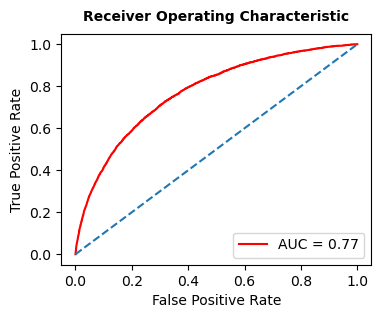

In [143]:
# Représentation graphique de la ROC_curve
ROC_curve('LightGBM_corrs_rem_poly', lgb_balanced, val_poly, val_poly_labels)

<span class="text-info">*Observations :*  
L'entrainement de ce modèle sur les données sans colinéarité avec les features polynomiales laisse apparaitre un sur-apprentissage plus important. Les temps d'apprentissage et de prédiction sont plus longs. 

##### Features métier

In [144]:
# Chargement du dataset pour modélisation
train_corrs_rem_domain = pd.read_csv('train_corrs_removed_domain.csv')

# Suppression de la target
app_train_domain_target = train_corrs_rem_domain['TARGET']
app_train_domain = train_corrs_rem_domain.drop(columns = ['SK_ID_CURR', 'TARGET'])
features_domain = app_train_domain.columns

In [145]:
# Imputation des valeurs manquantes par la médiane
imputer = SimpleImputer(strategy = 'median')
imputer.fit(app_train_domain)
app_train_domain = imputer.transform(app_train_domain)

In [146]:
# Splitting du jeu train en train+val
train_domain, val_domain, \
              train_domain_labels, \
              val_domain_labels = train_test_split(app_train_domain, 
                                                   app_train_domain_target, 
                                                   test_size = 0.2, 
                                                   stratify = app_train_domain_target,
                                                   random_state = 56)

In [147]:
print('Training shape: ', train_domain.shape)
print('Validation shape: ', val_domain.shape)

Training shape:  (246008, 627)
Validation shape:  (61503, 627)


[100]	training's binary_logloss: 0.51902	training's CustomScore: 193010	training's F1_score: 0.0568401	valid_1's binary_logloss: 0.539073	valid_1's CustomScore: 48588	valid_1's F1_score: 0.0445046
[200]	training's binary_logloss: 0.478115	training's CustomScore: 188496	training's F1_score: 0.0989914	valid_1's binary_logloss: 0.514009	valid_1's CustomScore: 47883	valid_1's F1_score: 0.0727682
[300]	training's binary_logloss: 0.445639	training's CustomScore: 186536	training's F1_score: 0.116131	valid_1's binary_logloss: 0.493776	valid_1's CustomScore: 47710	valid_1's F1_score: 0.0791488
[400]	training's binary_logloss: 0.417241	training's CustomScore: 184792	training's F1_score: 0.131173	valid_1's binary_logloss: 0.475725	valid_1's CustomScore: 47766	valid_1's F1_score: 0.0774818
[500]	training's binary_logloss: 0.391462	training's CustomScore: 182737	training's F1_score: 0.148609	valid_1's binary_logloss: 0.45922	valid_1's CustomScore: 47756	valid_1's F1_score: 0.0780524
Results on vali

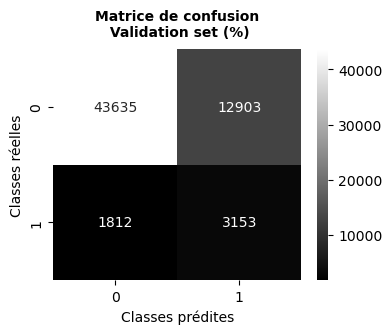

In [148]:
# Création du modèle 
lgb_balanced = lgb.LGBMClassifier(objective = 'binary', 
                                  boosting_type = 'goss', 
                                  n_estimators = 10000, 
                                  class_weight = 'balanced')

# Calcul des différents scores et compilation des scores du modèle dans un dataframe
df_results = scores('LightGBM_corrs_rem_domain', lgb_balanced, train_domain, val_domain, 
                    train_domain_labels, val_domain_labels, results, 
                    fit_params = {'early_stopping_rounds': 200, 
                                  'eval_set': [(train_domain, train_domain_labels), 
                                               (val_domain, val_domain_labels)], 
                                  'eval_metric': CustomScores, 
                                  'verbose': 100},
                    threshold = 0.5)

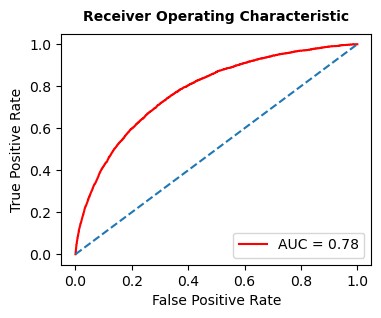

In [149]:
# Représentation graphique de la ROC_curve
ROC_curve('LightGBM_corrs_rem_domain', lgb_balanced, val_domain, val_domain_labels)

<span class="text-info">*Observations :*  
L'entrainement de ce modèle sur les données sans colinéarité avec les features métier donne une nouvelle fois des performances similaires en termes de nombres de FN, FP et légerement supérieures pour les autres métriques, bien qu'un surapprentissage plus important apparaisse.

#### Optimisation avec validation croisée

In [150]:
# Tri des resultats afin de mener l'optimisation des paramètres sur le meilleur feature engineering
df_results.sort_values(by='cost').head(10)

,classifier,TN_val,FP_val,FN_val,TP_val,cost,train_accuracy,val_accuracy,train_precision,val_precision,train_recall,val_recall,train_F1_score,val_F1_score,train_F2_score,val_F2_score,train_roc_auc,val_roc_auc,train_time,predict_time
18,LightGBM_balanced_custom_threshold_0.5,42136,14402,1629,3336,30692,0.756244,0.739346,0.218262,0.188071,0.782226,0.671903,0.341294,0.293882,0.515715,0.443641,0.849817,0.778624,211.608164,0.148474
3,LightGBM_balanced,42001,14537,1629,3336,30827,0.754077,0.737151,0.216133,0.186650,0.779003,0.671903,0.338382,0.292145,0.512214,0.442053,0.846455,0.778751,34.627094,0.137321
34,LightGBM_corrs_rem_domain,43635,12903,1812,3153,31023,0.788503,0.760743,0.252767,0.196375,0.828046,0.635045,0.387306,0.299986,0.569031,0.438941,0.889218,0.778695,250.654445,0.211539
28,LightGBM_balanced_custom_cors_rem_threshold_0.5,42463,14075,1695,3270,31025,0.764268,0.743590,0.226370,0.188527,0.794209,0.658610,0.352320,0.293142,0.528876,0.439457,0.860951,0.776599,214.924323,0.157571
23,LightGBM_corrs_removed,42463,14075,1695,3270,31025,0.764268,0.743590,0.226370,0.188527,0.794209,0.658610,0.352320,0.293142,0.528876,0.439457,0.860951,0.776599,211.579702,0.157393
17,LightGBM_balanced_custom_threshold_0.4,38669,17869,1325,3640,31119,0.719375,0.687918,0.215146,0.169231,0.935096,0.733132,0.349809,0.274987,0.560184,0.439943,0.907767,0.777727,332.620240,0.251612
27,LightGBM_balanced_custom_cors_rem_threshold_0.4,40918,15620,1561,3404,31230,0.766060,0.720648,0.252395,0.178932,0.967271,0.685599,0.400329,0.283797,0.617482,0.437712,0.943916,0.772210,435.432758,0.378047
9,LightGBM_under_0.2_balanced,41545,14993,1646,3319,31453,0.744419,0.729460,0.366424,0.181247,0.731722,0.668479,0.488315,0.285174,0.610081,0.434743,0.817789,0.770868,22.568989,0.098162
16,LightGBM_balanced_custom_threshold_0.3,39924,16614,1507,3458,31684,0.766951,0.705364,0.257104,0.172280,0.998590,0.696475,0.408924,0.276231,0.633303,0.432986,0.984066,0.766195,765.163819,0.607139
11,LightGBM_under_0.6_balanced,40242,16296,1540,3425,31696,0.745185,0.709998,0.636958,0.173673,0.745267,0.689829,0.686869,0.277485,0.720755,0.432657,0.825566,0.764986,18.155201,0.108071


<span class="text-info">*Observations :*   
Comme conclu précédemment, le modèle LightGBM "LightGBM_corrs_rem_domain" (sur les données dont les corrélations fortes ont été supprimées, et les features métier ajoutées) possède un léger surapprentissage.  
Essayons d'améliorer les performances et limiter le sur-apprentissage à l'aide d'une optimisation des paramètres avec validation croisée. 

In [151]:
# Définition des scores pour la recherche sur grille

# Définition de la fonction custom afin de minimiser les FN et FP 
# (avec un poids plus important de minimisation des FN (FN 10 fois plus coûteux))
def CustomScore(y_true, p_pred): 
    fn_value = 10
    fp_value = 1
    y_pred = (p_pred >= 0.5).astype(int) # threshold = 0.5
    # Récupération des TN, FP, FN, TP
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    # Définition de la métrique à minimiser
    score = fn*fn_value + fp*fp_value
    return score

custom_score = make_scorer(CustomScore, greater_is_better = False, needs_proba = True)


# Définition du F1_score que l'on veut maximiser
def F1_score(y_true, y_pred): 
    return f1_score(y_true, y_pred)

F1_score = make_scorer(F1_score, greater_is_better = True) 

In [162]:
# Définition du modèle
lgb_balanced_opt = lgb.LGBMClassifier(objective = 'binary', 
                                      boosting_type = 'goss', 
                                      n_estimators = 10000, 
                                      class_weight = 'balanced',
                                      n_jobs = -1)

# Grille de paramètres
lgbm_param_grid = {'num_leaves': np.linspace(10, 80, 4, dtype = 'int'),
                   'min_child_samples': stats.randint(100, 500),
                   'min_child_weight': [1e-5, 1e-2, 1, 1e2, 1e4],
                   'subsample': stats.uniform(loc = 0.2, scale = 0.8),
                   'colsample_bytree': stats.uniform(loc = 0.4, scale = 0.6),
                   'reg_alpha': [0.1, 1, 10, 100],
                   'reg_lambda': [0.1, 1, 10, 50, 100]} 

# Définition de la recherche sur grille
grid_cv_lgbm = RandomizedSearchCV(lgb_balanced_opt,
                                  lgbm_param_grid, 
                                  n_iter = 10, cv = 5,
                                  scoring = {'custom_score': custom_score,
                                             'F1_score': F1_score},
                                  refit = 'custom_score',
                                  n_jobs = -1,
                                  return_train_score = True,
                                  verbose = True,
                                  random_state = 56)

# Exécution de la recherche sur grille sur le jeu d'entrainement
start = time.time()
grid_cv_lgbm_model = grid_cv_lgbm.fit(train_domain, train_domain_labels)
end = time.time()

# Affichage des paramètres optimaux
print("Optimization time: {} seconds".format(end-start))
print("The optimal parameters are {} with a score of {:.2f}"\
      .format(grid_cv_lgbm.best_params_, 
              grid_cv_lgbm.best_score_))

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Optimization time: 15575.228136062622 seconds
The optimal parameters are {'colsample_bytree': 0.7378099800189732, 'min_child_samples': 364, 'min_child_weight': 10000.0, 'num_leaves': 56, 'reg_alpha': 100, 'reg_lambda': 0.1, 'subsample': 0.8500815748468737} with a score of -25644.00


[100]	training's binary_logloss: 0.585707	training's CustomScore: 198398	training's F1_score: 0.00211172	valid_1's binary_logloss: 0.587694	valid_1's CustomScore: 49605	valid_1's F1_score: 0.00201005
[200]	training's binary_logloss: 0.577007	training's CustomScore: 196375	training's F1_score: 0.0238459	valid_1's binary_logloss: 0.579769	valid_1's CustomScore: 49057	valid_1's F1_score: 0.0255553
[300]	training's binary_logloss: 0.573123	training's CustomScore: 195068	training's F1_score: 0.037831	valid_1's binary_logloss: 0.576758	valid_1's CustomScore: 48721	valid_1's F1_score: 0.039853
[400]	training's binary_logloss: 0.570552	training's CustomScore: 194375	training's F1_score: 0.0449644	valid_1's binary_logloss: 0.574286	valid_1's CustomScore: 48559	valid_1's F1_score: 0.0462072
[500]	training's binary_logloss: 0.568541	training's CustomScore: 194041	training's F1_score: 0.0484273	valid_1's binary_logloss: 0.572502	valid_1's CustomScore: 48464	valid_1's F1_score: 0.0501916
[600]	trai

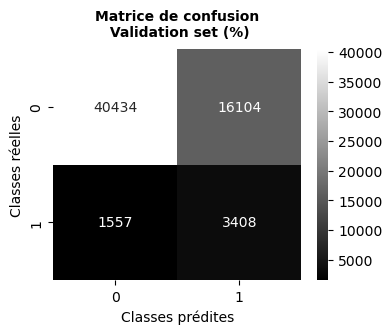

In [163]:
# Lancement de l'algorithme avec les paramètres optimisés sur tout le jeu de données
lgb_balanced_opt_domain = lgb.LGBMClassifier(objective = 'binary', 
                                      boosting_type = 'goss', 
                                      n_estimators = 10000, 
                                      class_weight = 'balanced',
                                      n_jobs = -1,
                                      **grid_cv_lgbm.best_params_)

df_results = scores('lgb_balanced_opt_domain', lgb_balanced_opt_domain, train_domain, val_domain, 
                     train_domain_labels, val_domain_labels, results, 
                     fit_params = {'early_stopping_rounds': 200, 
                                  'eval_set': [(train_domain, train_domain_labels), 
                                               (val_domain, val_domain_labels)], 
                                  'eval_metric': CustomScores, 
                                  'verbose': 100},
                     threshold = 0.5)

In [171]:
df_results.sort_values(by='cost').head(10)

,classifier,TN_val,FP_val,FN_val,TP_val,cost,train_accuracy,val_accuracy,train_precision,val_precision,train_recall,val_recall,train_F1_score,val_F1_score,train_F2_score,val_F2_score,train_roc_auc,val_roc_auc,train_time,predict_time
18,LightGBM_balanced_custom_threshold_0.5,42136,14402,1629,3336,30692,0.756244,0.739346,0.218262,0.188071,0.782226,0.671903,0.341294,0.293882,0.515715,0.443641,0.849817,0.778624,211.608164,0.148474
3,LightGBM_balanced,42001,14537,1629,3336,30827,0.754077,0.737151,0.216133,0.186650,0.779003,0.671903,0.338382,0.292145,0.512214,0.442053,0.846455,0.778751,34.627094,0.137321
34,LightGBM_corrs_rem_domain,43635,12903,1812,3153,31023,0.788503,0.760743,0.252767,0.196375,0.828046,0.635045,0.387306,0.299986,0.569031,0.438941,0.889218,0.778695,250.654445,0.211539
28,LightGBM_balanced_custom_cors_rem_threshold_0.5,42463,14075,1695,3270,31025,0.764268,0.743590,0.226370,0.188527,0.794209,0.658610,0.352320,0.293142,0.528876,0.439457,0.860951,0.776599,214.924323,0.157571
23,LightGBM_corrs_removed,42463,14075,1695,3270,31025,0.764268,0.743590,0.226370,0.188527,0.794209,0.658610,0.352320,0.293142,0.528876,0.439457,0.860951,0.776599,211.579702,0.157393
17,LightGBM_balanced_custom_threshold_0.4,38669,17869,1325,3640,31119,0.719375,0.687918,0.215146,0.169231,0.935096,0.733132,0.349809,0.274987,0.560184,0.439943,0.907767,0.777727,332.620240,0.251612
27,LightGBM_balanced_custom_cors_rem_threshold_0.4,40918,15620,1561,3404,31230,0.766060,0.720648,0.252395,0.178932,0.967271,0.685599,0.400329,0.283797,0.617482,0.437712,0.943916,0.772210,435.432758,0.378047
9,LightGBM_under_0.2_balanced,41545,14993,1646,3319,31453,0.744419,0.729460,0.366424,0.181247,0.731722,0.668479,0.488315,0.285174,0.610081,0.434743,0.817789,0.770868,22.568989,0.098162
35,lgb_balanced_opt_domain,40434,16104,1557,3408,31674,0.715395,0.712843,0.181017,0.174662,0.716566,0.686405,0.289022,0.278465,0.450186,0.432795,0.786841,0.768350,725.397872,0.313601
16,LightGBM_balanced_custom_threshold_0.3,39924,16614,1507,3458,31684,0.766951,0.705364,0.257104,0.172280,0.998590,0.696475,0.408924,0.276231,0.633303,0.432986,0.984066,0.766195,765.163819,0.607139


<span class="text-info">*Observations :*  
Le modèle optimisé perd légèrement en performances en termes de coût, mais, contrairement à toutes les autres simulations, les performances train et val sont équivalentes sur toutes les métriques.  
L'optimisation des paramètres avec validation croisée a donc permis de limiter le surapprentissage. 

In [172]:
# Enregistrement des resultats dans un fichier .csv
df_results.to_csv('models_results.csv', index = False) 

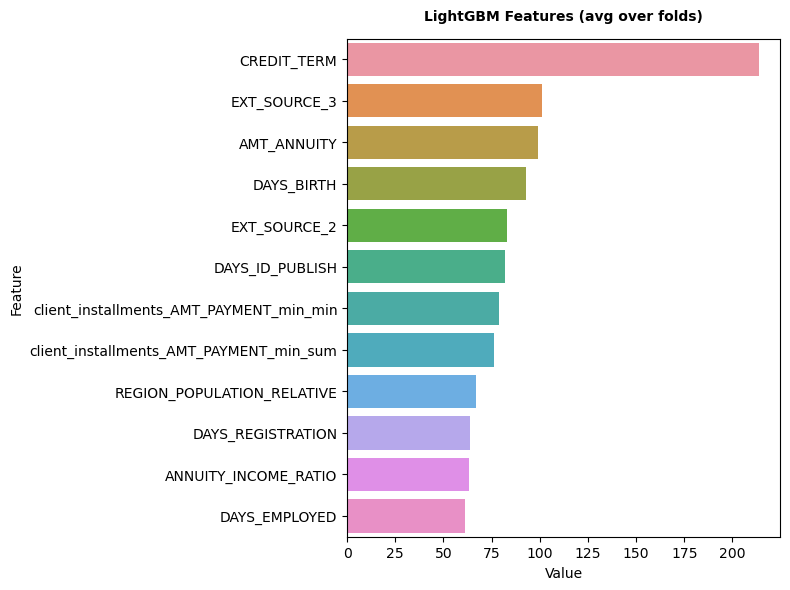

In [173]:
# Visualisation de l'importance des features
feature_imp = pd.DataFrame(sorted(zip(lgb_balanced_opt_domain.feature_importances_, features_domain)), 
                           columns = ['Value', 'Feature'])

plt.figure(figsize = (8, 6))
sns.barplot(x = "Value", y = "Feature", 
            data = feature_imp.sort_values(by = "Value", 
                                           ascending = False).head(12))
plt.title('LightGBM Features (avg over folds)', 
          fontsize = 10, y = 1.02, fontweight = 'bold')
plt.tight_layout()
plt.savefig('Représentation_graph/lgbm-opt_importances.png', 
            bbox_inches = "tight", transparent = True)

<span class="text-info">*Observations :*  
Ce graphique montre que les features ayant le plus d'impact dans le modèle optimisé sont la durée du crédit, les features inconnues EXT_SOURCE_2 et 3, le montant des mensualités et l'âge du client.

## ENREGISTREMENT DES DONNEES POUR DASHBOARD

In [174]:
# Echantillonage des données pour limiter la taille du fichier
app_train_sampled = train_corrs_rem_domain.sample(n=20000)
app_train_sampled.to_csv('app_train_sampled.csv', index = False) 

## ANALYSE DU DATADRIFT

In [175]:
# Récupération des features les plus importantes du modèle
feature_imp_sort = feature_imp.sort_values(by = "Value", 
                                           ascending = False)
features_datadrift = feature_imp_sort['Feature'].head(80).tolist()

In [176]:
# Définition des données références et des nouvelles données
reference = train_corrs_rem_domain.loc[:, features_datadrift]
current = test_corrs_removed_domain.loc[:, features_datadrift]

In [177]:
# Génération du rapport datadrift
report = Report(metrics=[DataDriftPreset()])
report.run(reference_data=reference, current_data=current)
report.save_html('data_drift_report.html')

<span class="text-info">*Observations :*  
En examinant le fichier html dans le navigateur, il semble que parmi les 80 variables les plus décisives du modèle, seulement 16,3 % ont drifté sur les nouvelles données. La conclusion du rapport est que sur l'ensemble des données, le datadrift n'est pas detecté (seuil à 50%). 